# Installing Dependencies

In [1]:
pip install opencv-python numpy matplotlib


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: /Users/adrianfernandes/anaconda3/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install numpy==1.26.4


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: /Users/adrianfernandes/anaconda3/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


# Rotating the Images

Applying rotation of 90 degrees
Saved rotated image to: rotated_image(1243-3).jpg


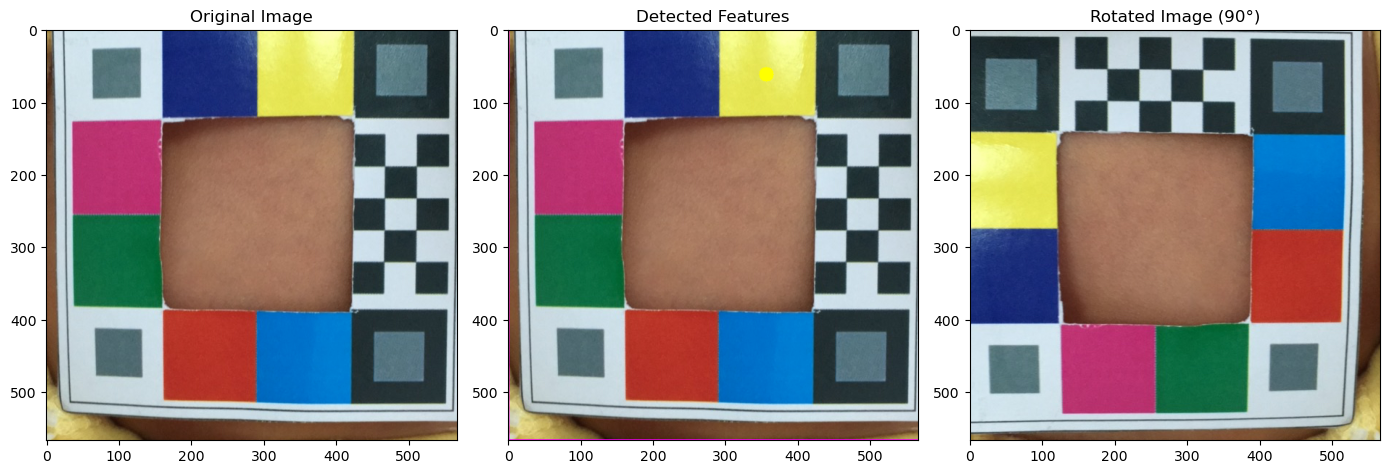

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import argparse
import sys

def rotate_color_card(image_path='Raw/1243-3.jpg', output_path=None, show_result=True):
    img = cv2.imread('Raw/1243-3.jpg')  
    if img is None:
        raise ValueError(f"Could not read image: {image_path}")

    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lower_yellow = np.array([20, 100, 100])
    upper_yellow = np.array([35, 255, 255])
    yellow_mask = cv2.inRange(hsv, lower_yellow, upper_yellow)
    yellow_contours, _ = cv2.findContours(yellow_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    def find_checkerboard(image):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                            cv2.THRESH_BINARY, 11, 2)
        contours, _ = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
        min_area = 100  
        contours = [c for c in contours if cv2.contourArea(c) > min_area]
        num_squares = len(contours)
        if num_squares >= 5:
            all_contours = np.vstack(contours)
            x, y, w, h = cv2.boundingRect(all_contours)
            return (x, y, w, h)
            
        return None
        
    checkerboard_box = find_checkerboard(img)
    debug_img = img.copy()
    yellow_center = None
    if yellow_contours:
        yellow_contour = max(yellow_contours, key=cv2.contourArea)
        M = cv2.moments(yellow_contour)
        if M["m00"] != 0:
            yellow_cx = int(M["m10"] / M["m00"])
            yellow_cy = int(M["m01"] / M["m00"])
            yellow_center = (yellow_cx, yellow_cy)
            cv2.circle(debug_img, yellow_center, 10, (0, 255, 255), -1)
    if checkerboard_box:
        x, y, w, h = checkerboard_box
        cv2.rectangle(debug_img, (x, y), (x + w, y + h), (255, 0, 255), 2)
    height, width = img.shape[:2]
    center_x, center_y = width // 2, height // 2
    rotation_angle = 270
        
    if yellow_center and checkerboard_box:
        cb_x = checkerboard_box[0] + checkerboard_box[2] // 2
        cb_y = checkerboard_box[1] + checkerboard_box[3] // 2
        yellow_left = yellow_center[0] < center_x
        yellow_top = yellow_center[1] < center_y
        cb_left = cb_x < center_x
        cb_top = cb_y < center_y
            
        if yellow_left and cb_top:
            # Already in desired orientation
            rotation_angle = 0
        elif yellow_top and not cb_left:
            # Yellow top, checkerboard right -> 90 degrees counterclockwise
            rotation_angle = 90
        elif not yellow_left and not cb_top:
            # Yellow right, checkerboard bottom -> 180 degrees
            rotation_angle = 180
        elif not yellow_top and cb_left:
            # Yellow bottom, checkerboard left -> 270 degrees counterclockwise
            rotation_angle = 270
        
    print(f"Applying rotation of {rotation_angle} degrees")

    rotation_matrix = cv2.getRotationMatrix2D((center_x, center_y), rotation_angle, 1)
    rotated_img = cv2.warpAffine(img, rotation_matrix, (width, height), 
                                    flags=cv2.INTER_LINEAR, 
                                    borderMode=cv2.BORDER_CONSTANT,
                                    borderValue=(255, 255, 255))

    if output_path:
        cv2.imwrite(output_path, rotated_img)
        print(f"Saved rotated image to: {output_path}")
    if show_result:
        plt.figure(figsize=(14, 6))      
        plt.subplot(1, 3, 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title("Original Image")
        plt.subplot(1, 3, 2)
        plt.imshow(cv2.cvtColor(debug_img, cv2.COLOR_BGR2RGB))
        plt.title("Detected Features")        
        plt.subplot(1, 3, 3)
        plt.imshow(cv2.cvtColor(rotated_img, cv2.COLOR_BGR2RGB))
        plt.title(f"Rotated Image ({rotation_angle}°)")        
        plt.tight_layout()
        plt.show()
        
    return rotated_img

    
if __name__ == "__main__":
    if 'ipykernel' in sys.modules:
        sys.argv = ['ipykernel_launcher.py', 'image.jpg', '--output', 'rotated_image(1243-3).jpg']

    parser = argparse.ArgumentParser(description='Rotate color card to specific orientation')
    parser.add_argument('input', help='Input image path')
    parser.add_argument('--output', help='Output path for rotated image', default=None)
    parser.add_argument('--no-display', action='store_true', help='Do not display result')  
    args = parser.parse_args()  
    rotate_color_card(args.input, args.output, not args.no_display)

# Applying Co-ordinates

In [4]:
import cv2
import numpy as np
import os

def process_and_save_color_cards(image_folder, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    image_paths = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    if not image_paths:
        print("No image files found in the input folder.")
        return

    coordinates = {
        "yellow": (80, 220),  
        "blue_left": (85, 370),
        "red_right": (500, 370),
        "green": (350, 500),
        "checkboard_top_center": (250, 100),
        "blue_right": (500, 252),
        "pink_bottom": (200, 500),
    }

    for image_path in image_paths:
        img = cv2.imread(image_path)
        img_copy = img.copy()

        for color, (x, y) in coordinates.items():
            cv2.circle(img_copy, (x, y), 5, (0, 0, 255), -1)  # Red circle
            cv2.putText(img_copy, color, (x + 10, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)

        output_filename = os.path.basename(image_path)
        output_path = os.path.join(output_folder, output_filename)
        cv2.imwrite(output_path, img_copy)
        print(f"Saved: {output_path}")

input_folder = "Images"  
output_folder = "output_images" 
process_and_save_color_cards(input_folder, output_folder)

Saved: output_images/rotated_image(0992-2).jpg
Saved: output_images/rotated_image(0368-1).jpg
Saved: output_images/rotated_image(0261-2).jpg
Saved: output_images/rotated_image(0530-2).jpg
Saved: output_images/rotated_image(1007-2).jpg
Saved: output_images/rotated_image(1107-2).jpg
Saved: output_images/rotated_image(0539-1).jpg
Saved: output_images/rotated_image(0315-1).jpg
Saved: output_images/rotated_image(0444-1).jpg
Saved: output_images/rotated_image(0347-3).jpg
Saved: output_images/rotated_image(0516-3).jpg
Saved: output_images/rotated_image(1021-3).jpg
Saved: output_images/rotated_image(0247-3).jpg
Saved: output_images/rotated_image(1296-3).jpg
Saved: output_images/rotated_image(0427-1).jpg
Saved: output_images/rotated_image(0699-2).jpg
Saved: output_images/rotated_image(0575-3).jpg
Saved: output_images/rotated_image(0276-1).jpg
Saved: output_images/rotated_image(0527-1).jpg
Saved: output_images/rotated_image(1010-1).jpg
Saved: output_images/rotated_image(0885-1).jpg
Saved: output

Saved: output_images/rotated_image(0774-2).jpg
Saved: output_images/rotated_image(0968-1).jpg
Saved: output_images/rotated_image(0861-2).jpg
Saved: output_images/rotated_image(0728-1).jpg
Saved: output_images/rotated_image(0079-1).jpg
Saved: output_images/rotated_image(1316-2).jpg
Saved: output_images/rotated_image(0596-2).jpg
Saved: output_images/rotated_image(0834-2).jpg
Saved: output_images/rotated_image(0934-2).jpg
Saved: output_images/rotated_image(1262-1).jpg
Saved: output_images/rotated_image(0056-3).jpg
Saved: output_images/rotated_image(1230-3).jpg
Saved: output_images/rotated_image(0156-3).jpg
Saved: output_images/rotated_image(1330-3).jpg
Saved: output_images/rotated_image(0104-1).jpg
Saved: output_images/rotated_image(0940-1).jpg
Saved: output_images/rotated_image(0949-2).jpg
Saved: output_images/rotated_image(0812-3).jpg
Saved: output_images/rotated_image(0971-3).jpg
Saved: output_images/rotated_image(0823-1).jpg
Saved: output_images/rotated_image(0871-3).jpg
Saved: output

Saved: output_images/rotated_image(0631-2).jpg
Saved: output_images/rotated_image(1306-2).jpg
Saved: output_images/rotated_image(0850-1).jpg
Saved: output_images/rotated_image(0802-3).jpg
Saved: output_images/rotated_image(0902-3).jpg
Saved: output_images/rotated_image(0950-1).jpg
Saved: output_images/rotated_image(1320-3).jpg
Saved: output_images/rotated_image(0146-3).jpg
Saved: output_images/rotated_image(0114-1).jpg
Saved: output_images/rotated_image(1097-3).jpg
Saved: output_images/rotated_image(0014-1).jpg
Saved: output_images/rotated_image(1272-1).jpg
Saved: output_images/rotated_image(0745-1).jpg
Saved: output_images/rotated_image(1220-3).jpg
Saved: output_images/rotated_image(0046-3).jpg
Saved: output_images/rotated_image(0583-1).jpg
Saved: output_images/rotated_image(0280-3).jpg
Saved: output_images/rotated_image(1203-1).jpg
Saved: output_images/rotated_image(0065-1).jpg
Saved: output_images/rotated_image(0037-3).jpg
Saved: output_images/rotated_image(1251-3).jpg
Saved: output

Saved: output_images/rotated_image(1261-2).jpg
Saved: output_images/rotated_image(1268-1).jpg
Saved: output_images/rotated_image(0943-2).jpg
Saved: output_images/rotated_image(1347-3).jpg
Saved: output_images/rotated_image(1315-1).jpg
Saved: output_images/rotated_image(0495-1).jpg
Saved: output_images/rotated_image(1215-1).jpg
Saved: output_images/rotated_image(1247-3).jpg
Saved: output_images/rotated_image(0770-3).jpg
Saved: output_images/rotated_image(0296-3).jpg
Saved: output_images/rotated_image(0837-1).jpg
Saved: output_images/rotated_image(0965-3).jpg
Saved: output_images/rotated_image(0937-1).jpg
Saved: output_images/rotated_image(0954-1).jpg
Saved: output_images/rotated_image(1193-3).jpg
Saved: output_images/rotated_image(0142-3).jpg
Saved: output_images/rotated_image(1324-3).jpg
Saved: output_images/rotated_image(0019-2).jpg
Saved: output_images/rotated_image(0641-1).jpg
Saved: output_images/rotated_image(0110-1).jpg
Saved: output_images/rotated_image(1276-1).jpg
Saved: output

Saved: output_images/rotated_image(0450-1).jpg
Saved: output_images/rotated_image(1167-1).jpg
Saved: output_images/rotated_image(0208-2).jpg
Saved: output_images/rotated_image(0353-3).jpg
Saved: output_images/rotated_image(0559-2).jpg
Saved: output_images/rotated_image(0099-3).jpg
Saved: output_images/rotated_image(1048-3).jpg
Saved: output_images/rotated_image(1113-2).jpg
Saved: output_images/rotated_image(0275-2).jpg
Saved: output_images/rotated_image(1148-3).jpg
Saved: output_images/rotated_image(1013-2).jpg
Saved: output_images/rotated_image(0524-2).jpg
Saved: output_images/rotated_image(0886-2).jpg
Saved: output_images/rotated_image(0986-2).jpg
Saved: output_images/rotated_image(0099-2).jpg
Saved: output_images/rotated_image(1113-3).jpg
Saved: output_images/rotated_image(1048-2).jpg
Saved: output_images/rotated_image(1141-1).jpg
Saved: output_images/rotated_image(0576-1).jpg
Saved: output_images/rotated_image(1041-1).jpg
Saved: output_images/rotated_image(1013-3).jpg
Saved: output

Saved: output_images/rotated_image(1324-2).jpg
Saved: output_images/rotated_image(0142-2).jpg
Saved: output_images/rotated_image(0119-3).jpg
Saved: output_images/rotated_image(0713-2).jpg
Saved: output_images/rotated_image(1224-2).jpg
Saved: output_images/rotated_image(1347-2).jpg
Saved: output_images/rotated_image(0779-1).jpg
Saved: output_images/rotated_image(0028-1).jpg
Saved: output_images/rotated_image(0128-1).jpg
Saved: output_images/rotated_image(1247-2).jpg
Saved: output_images/rotated_image(0770-2).jpg
Saved: output_images/rotated_image(0296-2).jpg
Saved: output_images/rotated_image(0965-2).jpg
Saved: output_images/rotated_image(1261-3).jpg
Saved: output_images/rotated_image(0704-1).jpg
Saved: output_images/rotated_image(1233-1).jpg
Saved: output_images/rotated_image(0055-1).jpg
Saved: output_images/rotated_image(0604-1).jpg
Saved: output_images/rotated_image(1333-1).jpg
Saved: output_images/rotated_image(1184-1).jpg
Saved: output_images/rotated_image(0943-3).jpg
Saved: output

Saved: output_images/rotated_image(1141-2).jpg
Saved: output_images/rotated_image(0450-3).jpg
Saved: output_images/rotated_image(1167-3).jpg
Saved: output_images/rotated_image(0353-1).jpg
Saved: output_images/rotated_image(1282-1).jpg
Saved: output_images/rotated_image(0550-3).jpg
Saved: output_images/rotated_image(1067-3).jpg
Saved: output_images/rotated_image(1104-3).jpg
Saved: output_images/rotated_image(0568-2).jpg
Saved: output_images/rotated_image(0330-1).jpg
Saved: output_images/rotated_image(1156-1).jpg
Saved: output_images/rotated_image(0187-1).jpg
Saved: output_images/rotated_image(0561-1).jpg
Saved: output_images/rotated_image(1056-1).jpg
Saved: output_images/rotated_image(0339-2).jpg
Saved: output_images/rotated_image(1004-3).jpg
Saved: output_images/rotated_image(0262-3).jpg
Saved: output_images/rotated_image(0087-1).jpg
Saved: output_images/rotated_image(0244-2).jpg
Saved: output_images/rotated_image(1179-3).jpg
Saved: output_images/rotated_image(1022-2).jpg
Saved: output

Saved: output_images/rotated_image(1053-3).jpg
Saved: output_images/rotated_image(0781-1).jpg
Saved: output_images/rotated_image(1022-3).jpg
Saved: output_images/rotated_image(1179-2).jpg
Saved: output_images/rotated_image(0244-3).jpg
Saved: output_images/rotated_image(0547-1).jpg
Saved: output_images/rotated_image(1070-1).jpg
Saved: output_images/rotated_image(1295-3).jpg
Saved: output_images/rotated_image(0316-1).jpg
Saved: output_images/rotated_image(0447-1).jpg
Saved: output_images/rotated_image(1170-1).jpg
Saved: output_images/rotated_image(1079-2).jpg
Saved: output_images/rotated_image(0568-3).jpg
Saved: output_images/rotated_image(1104-2).jpg
Saved: output_images/rotated_image(0262-2).jpg
Saved: output_images/rotated_image(1004-2).jpg
Saved: output_images/rotated_image(0339-3).jpg
Saved: output_images/rotated_image(0998-1).jpg
Saved: output_images/rotated_image(0450-2).jpg
Saved: output_images/rotated_image(1167-2).jpg
Saved: output_images/rotated_image(0208-1).jpg
Saved: output

Saved: output_images/rotated_image(1112-2).jpg
Saved: output_images/rotated_image(0987-2).jpg
Saved: output_images/rotated_image(0300-1).jpg
Saved: output_images/rotated_image(1166-1).jpg
Saved: output_images/rotated_image(1283-3).jpg
Saved: output_images/rotated_image(1034-3).jpg
Saved: output_images/rotated_image(0309-2).jpg
Saved: output_images/rotated_image(0458-2).jpg
Saved: output_images/rotated_image(0252-3).jpg
Saved: output_images/rotated_image(0551-1).jpg
Saved: output_images/rotated_image(1066-1).jpg
Saved: output_images/rotated_image(0990-1).jpg
Saved: output_images/rotated_image(0363-1).jpg
Saved: output_images/rotated_image(0432-1).jpg
Saved: output_images/rotated_image(0331-3).jpg
Saved: output_images/rotated_image(0685-1).jpg
Saved: output_images/rotated_image(0560-3).jpg
Saved: output_images/rotated_image(1057-3).jpg
Saved: output_images/rotated_image(0263-1).jpg
Saved: output_images/rotated_image(0532-1).jpg
Saved: output_images/rotated_image(0086-3).jpg
Saved: output

Saved: output_images/rotated_image(0964-3).jpg
Saved: output_images/rotated_image(0936-1).jpg
Saved: output_images/rotated_image(0864-3).jpg
Saved: output_images/rotated_image(1269-1).jpg
Saved: output_images/rotated_image(0657-2).jpg
Saved: output_images/rotated_image(1260-2).jpg
Saved: output_images/rotated_image(0006-2).jpg
Saved: output_images/rotated_image(0842-2).jpg
Saved: output_images/rotated_image(1332-1).jpg
Saved: output_images/rotated_image(0657-3).jpg
Saved: output_images/rotated_image(1185-1).jpg
Saved: output_images/rotated_image(0006-3).jpg
Saved: output_images/rotated_image(1260-3).jpg
Saved: output_images/rotated_image(0705-1).jpg
Saved: output_images/rotated_image(1232-1).jpg
Saved: output_images/rotated_image(1085-1).jpg
Saved: output_images/rotated_image(0842-3).jpg
Saved: output_images/rotated_image(0678-1).jpg
Saved: output_images/rotated_image(0129-1).jpg
Saved: output_images/rotated_image(1246-2).jpg
Saved: output_images/rotated_image(0771-2).jpg
Saved: output

Saved: output_images/rotated_image(0219-2).jpg
Saved: output_images/rotated_image(1124-3).jpg
Saved: output_images/rotated_image(1023-1).jpg
Saved: output_images/rotated_image(0217-3).jpg
Saved: output_images/rotated_image(1294-1).jpg
Saved: output_images/rotated_image(0446-3).jpg
Saved: output_images/rotated_image(1171-3).jpg
Saved: output_images/rotated_image(0317-3).jpg
Saved: output_images/rotated_image(0345-1).jpg
Saved: output_images/rotated_image(0569-1).jpg
Saved: output_images/rotated_image(0331-2).jpg
Saved: output_images/rotated_image(0560-2).jpg
Saved: output_images/rotated_image(1057-2).jpg
Saved: output_images/rotated_image(0338-1).jpg
Saved: output_images/rotated_image(0469-1).jpg
Saved: output_images/rotated_image(0086-2).jpg
Saved: output_images/rotated_image(1283-2).jpg
Saved: output_images/rotated_image(0252-2).jpg
Saved: output_images/rotated_image(0458-3).jpg
Saved: output_images/rotated_image(0309-3).jpg
Saved: output_images/rotated_image(1034-2).jpg
Saved: output

# Generating Matrices for each of the Colours

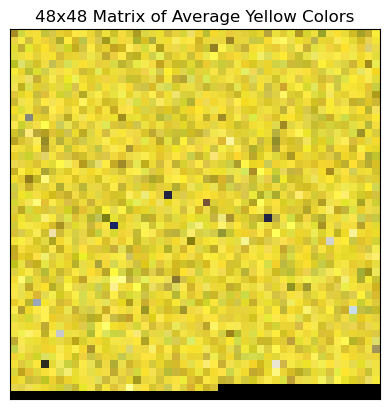

In [5]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import math

def get_grouped_average_yellow_colors(image_folder, coordinates, output_size=48):
    image_paths = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    num_images = len(image_paths)

    if not image_paths:
        print("No image files found in the input folder.")
        return []

    yellow_coords = coordinates.get("yellow")
    if yellow_coords is None:
        print("Warning: 'yellow' coordinates not found in the provided dictionary.")
        return []

    x_center, y_center = yellow_coords
    patch_size = 1  

    rows = output_size
    cols = output_size
    num_groups = rows * cols

    images_per_group = math.ceil(num_images / num_groups)

    all_average_yellows = []

    for i in range(num_groups):
        start_index = i * images_per_group
        end_index = min((i + 1) * images_per_group, num_images)
        group_paths = image_paths[start_index:end_index]
        group_yellow_patches = []

        if not group_paths:
            avg_color_bgr = [0, 0, 0]  
        else:
            for img_path in group_paths:
                img = cv2.imread(img_path)
                if img is None:
                    continue

                x_start = max(0, x_center - patch_size // 2)
                y_start = max(0, y_center - patch_size // 2)
                x_end = min(img.shape[1], x_center + patch_size // 2 + 1)
                y_end = min(img.shape[0], y_center + patch_size // 2 + 1)

                yellow_patch = img[y_start:y_end, x_start:x_end]
                resized_patch = cv2.resize(yellow_patch, (1, 1), interpolation=cv2.INTER_LINEAR)
                group_yellow_patches.append(resized_patch)

            if group_yellow_patches:
                avg_color_bgr = np.mean(np.concatenate(group_yellow_patches), axis=(0, 1)).astype(int)
            else:
                avg_color_bgr = [0, 0, 0] 

        all_average_yellows.append(avg_color_bgr)

    return all_average_yellows

def visualize_average_yellow_matrix(average_colors, output_size=48):
    rows = output_size
    cols = output_size
    color_matrix = np.zeros((rows, cols, 3), dtype=np.uint8)

    for i in range(rows):
        for j in range(cols):
            index = i * cols + j
            if index < len(average_colors):
                blue, green, red = average_colors[index]
                color_matrix[i, j] = [red, green, blue] 
            else:
                color_matrix[i, j] = [0, 0, 0] 

    plt.figure()
    plt.imshow(color_matrix)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title(f'{output_size}x{output_size} Matrix of Average Yellow Colors')
    plt.xticks([]) 
    plt.yticks([]) 
    plt.show()

input_folder = "Images"  
coordinates = {
    "yellow": (80, 220),  
}
output_matrix_size = 48

average_yellow_colors = get_grouped_average_yellow_colors(input_folder, coordinates, output_matrix_size)

if average_yellow_colors:
    visualize_average_yellow_matrix(average_yellow_colors, output_matrix_size)

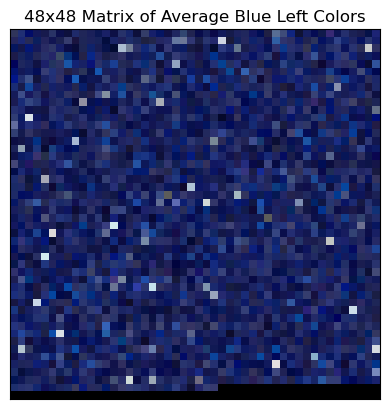

In [6]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import math

def get_grouped_average_color_matrix(image_folder, coordinates, color_name="blue_left", output_size=48):
    image_paths = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    num_images = len(image_paths)

    if not image_paths:
        print("No image files found in the input folder.")
        return []

    target_coords = coordinates.get(color_name)
    if target_coords is None:
        print(f"Warning: '{color_name}' coordinates not found in the provided dictionary.")
        return []

    x_center, y_center = target_coords
    patch_size = 1  
    rows = output_size
    cols = output_size
    num_groups = rows * cols

    images_per_group = math.ceil(num_images / num_groups)

    all_average_colors = []

    for i in range(num_groups):
        start_index = i * images_per_group
        end_index = min((i + 1) * images_per_group, num_images)
        group_paths = image_paths[start_index:end_index]
        group_color_patches = []

        if not group_paths:
            avg_color_bgr = [0, 0, 0]  
        else:
            for img_path in group_paths:
                img = cv2.imread(img_path)
                if img is None:
                    continue

                x_start = max(0, x_center - patch_size // 2)
                y_start = max(0, y_center - patch_size // 2)
                x_end = min(img.shape[1], x_center + patch_size // 2 + 1)
                y_end = min(img.shape[0], y_center + patch_size // 2 + 1)

                color_patch = img[y_start:y_end, x_start:x_end]
                resized_patch = cv2.resize(color_patch, (1, 1), interpolation=cv2.INTER_LINEAR)
                group_color_patches.append(resized_patch)

            if group_color_patches:
                avg_color_bgr = np.mean(np.concatenate(group_color_patches), axis=(0, 1)).astype(int)
            else:
                avg_color_bgr = [0, 0, 0] 

        all_average_colors.append(avg_color_bgr)

    return all_average_colors

def visualize_color_matrix(average_colors, color_name="unknown", output_size=48):
    rows = output_size
    cols = output_size
    color_matrix = np.zeros((rows, cols, 3), dtype=np.uint8)

    for i in range(rows):
        for j in range(cols):
            index = i * cols + j
            if index < len(average_colors):
                blue, green, red = average_colors[index]
                color_matrix[i, j] = [red, green, blue] 
            else:
                color_matrix[i, j] = [0, 0, 0] 

    plt.figure()
    plt.imshow(color_matrix)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title(f'{output_size}x{output_size} Matrix of Average {color_name.replace("_", " ").title()} Colors')
    plt.xticks([]) 
    plt.yticks([]) 
    plt.show()

input_folder = "Images"  
coordinates = {
    "blue_left": (85, 370), 
}
output_matrix_size = 48

average_blue_left_colors = get_grouped_average_color_matrix(input_folder, coordinates, color_name="blue_left", output_size=output_matrix_size)

if average_blue_left_colors:
    visualize_color_matrix(average_blue_left_colors, color_name="blue_left", output_size=output_matrix_size)

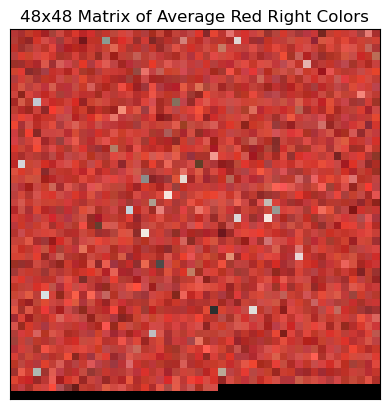

In [7]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import math

def get_grouped_average_color_matrix(image_folder, coordinates, color_name="red_right", output_size=48):
    image_paths = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    num_images = len(image_paths)

    if not image_paths:
        print("No image files found in the input folder.")
        return []

    target_coords = coordinates.get(color_name)
    if target_coords is None:
        print(f"Warning: '{color_name}' coordinates not found in the provided dictionary.")
        return []

    x_center, y_center = target_coords
    patch_size = 1  

    rows = output_size
    cols = output_size
    num_groups = rows * cols

    images_per_group = math.ceil(num_images / num_groups)

    all_average_colors = []

    for i in range(num_groups):
        start_index = i * images_per_group
        end_index = min((i + 1) * images_per_group, num_images)
        group_paths = image_paths[start_index:end_index]
        group_color_patches = []

        if not group_paths:
            avg_color_bgr = [0, 0, 0] 
        else:
            for img_path in group_paths:
                img = cv2.imread(img_path)
                if img is None:
                    continue

                x_start = max(0, x_center - patch_size // 2)
                y_start = max(0, y_center - patch_size // 2)
                x_end = min(img.shape[1], x_center + patch_size // 2 + 1)
                y_end = min(img.shape[0], y_center + patch_size // 2 + 1)

                color_patch = img[y_start:y_end, x_start:x_end]
                resized_patch = cv2.resize(color_patch, (1, 1), interpolation=cv2.INTER_LINEAR)
                group_color_patches.append(resized_patch)

            if group_color_patches:
                avg_color_bgr = np.mean(np.concatenate(group_color_patches), axis=(0, 1)).astype(int)
            else:
                avg_color_bgr = [0, 0, 0] 

        all_average_colors.append(avg_color_bgr)

    return all_average_colors

def visualize_color_matrix(average_colors, color_name="unknown", output_size=48):
    rows = output_size
    cols = output_size
    color_matrix = np.zeros((rows, cols, 3), dtype=np.uint8)

    for i in range(rows):
        for j in range(cols):
            index = i * cols + j
            if index < len(average_colors):
                blue, green, red = average_colors[index]
                color_matrix[i, j] = [red, green, blue]
            else:
                color_matrix[i, j] = [0, 0, 0] 

    plt.figure()
    plt.imshow(color_matrix)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title(f'{output_size}x{output_size} Matrix of Average {color_name.replace("_", " ").title()} Colors')
    plt.xticks([]) 
    plt.yticks([]) 
    plt.show()


input_folder = "Images"  
coordinates = {
    "red_right": (500, 370), 
}
output_matrix_size = 48

# Visualize the average red_right colors
average_red_right_colors = get_grouped_average_color_matrix(input_folder, coordinates, color_name="red_right", output_size=output_matrix_size)
if average_red_right_colors:
    visualize_color_matrix(average_red_right_colors, color_name="red_right", output_size=output_matrix_size)

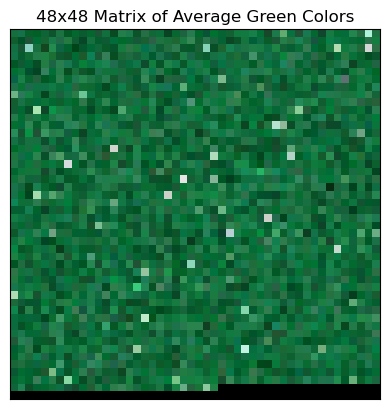

In [8]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import math

def get_grouped_average_color_matrix(image_folder, coordinates, color_name="green", output_size=48):
    image_paths = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    num_images = len(image_paths)

    if not image_paths:
        print("No image files found in the input folder.")
        return []

    target_coords = coordinates.get(color_name)
    if target_coords is None:
        print(f"Warning: '{color_name}' coordinates not found in the provided dictionary.")
        return []

    x_center, y_center = target_coords
    patch_size = 1  

    rows = output_size
    cols = output_size
    num_groups = rows * cols

    images_per_group = math.ceil(num_images / num_groups)

    all_average_colors = []

    for i in range(num_groups):
        start_index = i * images_per_group
        end_index = min((i + 1) * images_per_group, num_images)
        group_paths = image_paths[start_index:end_index]
        group_color_patches = []

        if not group_paths:
            avg_color_bgr = [0, 0, 0]  
        else:
            for img_path in group_paths:
                img = cv2.imread(img_path)
                if img is None:
                    continue

                x_start = max(0, x_center - patch_size // 2)
                y_start = max(0, y_center - patch_size // 2)
                x_end = min(img.shape[1], x_center + patch_size // 2 + 1)
                y_end = min(img.shape[0], y_center + patch_size // 2 + 1)

                color_patch = img[y_start:y_end, x_start:x_end]
                resized_patch = cv2.resize(color_patch, (1, 1), interpolation=cv2.INTER_LINEAR)
                group_color_patches.append(resized_patch)

            if group_color_patches:
                avg_color_bgr = np.mean(np.concatenate(group_color_patches), axis=(0, 1)).astype(int)
            else:
                avg_color_bgr = [0, 0, 0] 

        all_average_colors.append(avg_color_bgr)

    return all_average_colors

def visualize_color_matrix(average_colors, color_name="unknown", output_size=48):
    rows = output_size
    cols = output_size
    color_matrix = np.zeros((rows, cols, 3), dtype=np.uint8)

    for i in range(rows):
        for j in range(cols):
            index = i * cols + j
            if index < len(average_colors):
                blue, green, red = average_colors[index]
                color_matrix[i, j] = [red, green, blue] 
            else:
                color_matrix[i, j] = [0, 0, 0] 

    plt.figure()
    plt.imshow(color_matrix)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title(f'{output_size}x{output_size} Matrix of Average {color_name.replace("_", " ").title()} Colors')
    plt.xticks([])
    plt.yticks([]) 
    plt.show()

input_folder = "Images"  
coordinates = {
    "green": (350, 500),  
}
output_matrix_size = 48

average_green_colors = get_grouped_average_color_matrix(input_folder, coordinates, color_name="green", output_size=output_matrix_size)

if average_green_colors:
    visualize_color_matrix(average_green_colors, color_name="green", output_size=output_matrix_size)

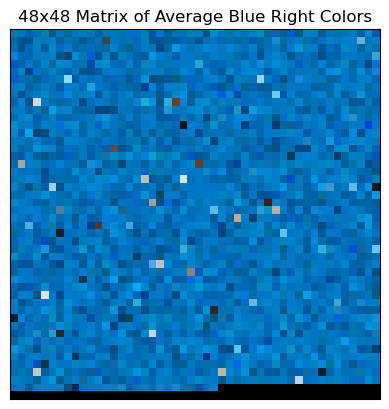

In [9]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import math

def get_grouped_average_color_matrix(image_folder, coordinates, color_name="blue_right", output_size=48):
    image_paths = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    num_images = len(image_paths)

    if not image_paths:
        print("No image files found in the input folder.")
        return []

    target_coords = coordinates.get(color_name)
    if target_coords is None:
        print(f"Warning: '{color_name}' coordinates not found in the provided dictionary.")
        return []

    x_center, y_center = target_coords
    patch_size = 1  

    rows = output_size
    cols = output_size
    num_groups = rows * cols

    images_per_group = math.ceil(num_images / num_groups)

    all_average_colors = []

    for i in range(num_groups):
        start_index = i * images_per_group
        end_index = min((i + 1) * images_per_group, num_images)
        group_paths = image_paths[start_index:end_index]
        group_color_patches = []

        if not group_paths:
            avg_color_bgr = [0, 0, 0] 
        else:
            for img_path in group_paths:
                img = cv2.imread(img_path)
                if img is None:
                    continue

                x_start = max(0, x_center - patch_size // 2)
                y_start = max(0, y_center - patch_size // 2)
                x_end = min(img.shape[1], x_center + patch_size // 2 + 1)
                y_end = min(img.shape[0], y_center + patch_size // 2 + 1)

                color_patch = img[y_start:y_end, x_start:x_end]
                resized_patch = cv2.resize(color_patch, (1, 1), interpolation=cv2.INTER_LINEAR)
                group_color_patches.append(resized_patch)

            if group_color_patches:
                avg_color_bgr = np.mean(np.concatenate(group_color_patches), axis=(0, 1)).astype(int)
            else:
                avg_color_bgr = [0, 0, 0]

        all_average_colors.append(avg_color_bgr)

    return all_average_colors

def visualize_color_matrix(average_colors, color_name="unknown", output_size=48):
    rows = output_size
    cols = output_size
    color_matrix = np.zeros((rows, cols, 3), dtype=np.uint8)

    for i in range(rows):
        for j in range(cols):
            index = i * cols + j
            if index < len(average_colors):
                blue, green, red = average_colors[index]
                color_matrix[i, j] = [red, green, blue] 
            else:
                color_matrix[i, j] = [0, 0, 0] 

    plt.figure()
    plt.imshow(color_matrix)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title(f'{output_size}x{output_size} Matrix of Average {color_name.replace("_", " ").title()} Colors')
    plt.xticks([])
    plt.yticks([]) 
    plt.show()
    
input_folder = "Images"  
coordinates = {
    "blue_right": (500, 220),  
}
output_matrix_size = 48

average_blue_right_colors = get_grouped_average_color_matrix(input_folder, coordinates, color_name="blue_right", output_size=output_matrix_size)

if average_blue_right_colors:
    visualize_color_matrix(average_blue_right_colors, color_name="blue_right", output_size=output_matrix_size)

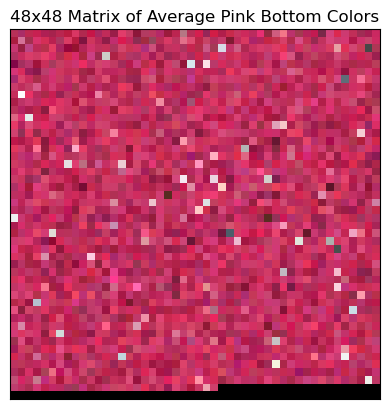

In [10]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import math

def get_grouped_average_color_matrix(image_folder, coordinates, color_name="pink_bottom", output_size=48):
    image_paths = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    num_images = len(image_paths)

    if not image_paths:
        print("No image files found in the input folder.")
        return []

    target_coords = coordinates.get(color_name)
    if target_coords is None:
        print(f"Warning: '{color_name}' coordinates not found in the provided dictionary.")
        return []

    x_center, y_center = target_coords
    patch_size = 1  

    rows = output_size
    cols = output_size
    num_groups = rows * cols

    images_per_group = math.ceil(num_images / num_groups)

    all_average_colors = []

    for i in range(num_groups):
        start_index = i * images_per_group
        end_index = min((i + 1) * images_per_group, num_images)
        group_paths = image_paths[start_index:end_index]
        group_color_patches = []

        if not group_paths:
            avg_color_bgr = [0, 0, 0]  
        else:
            for img_path in group_paths:
                img = cv2.imread(img_path)
                if img is None:
                    continue

                x_start = max(0, x_center - patch_size // 2)
                y_start = max(0, y_center - patch_size // 2)
                x_end = min(img.shape[1], x_center + patch_size // 2 + 1)
                y_end = min(img.shape[0], y_center + patch_size // 2 + 1)

                color_patch = img[y_start:y_end, x_start:x_end]
                resized_patch = cv2.resize(color_patch, (1, 1), interpolation=cv2.INTER_LINEAR)
                group_color_patches.append(resized_patch)

            if group_color_patches:
                avg_color_bgr = np.mean(np.concatenate(group_color_patches), axis=(0, 1)).astype(int)
            else:
                avg_color_bgr = [0, 0, 0] 

        all_average_colors.append(avg_color_bgr)

    return all_average_colors

def visualize_color_matrix(average_colors, color_name="unknown", output_size=48):
    rows = output_size
    cols = output_size
    color_matrix = np.zeros((rows, cols, 3), dtype=np.uint8)

    for i in range(rows):
        for j in range(cols):
            index = i * cols + j
            if index < len(average_colors):
                blue, green, red = average_colors[index]
                color_matrix[i, j] = [red, green, blue] # Matplotlib expects RGB
            else:
                color_matrix[i, j] = [0, 0, 0] # Black for any remaining cells

    plt.figure()
    plt.imshow(color_matrix)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title(f'{output_size}x{output_size} Matrix of Average {color_name.replace("_", " ").title()} Colors')
    plt.xticks([]) 
    plt.yticks([])
    plt.show()

input_folder = "Images" 
coordinates = {
    "pink_bottom": (200, 500),  
}
output_matrix_size = 48

average_pink_bottom_colors = get_grouped_average_color_matrix(input_folder, coordinates, color_name="pink_bottom", output_size=output_matrix_size)

if average_pink_bottom_colors:
    visualize_color_matrix(average_pink_bottom_colors, color_name="pink_bottom", output_size=output_matrix_size)

# Generating Histograms for each of the Colours

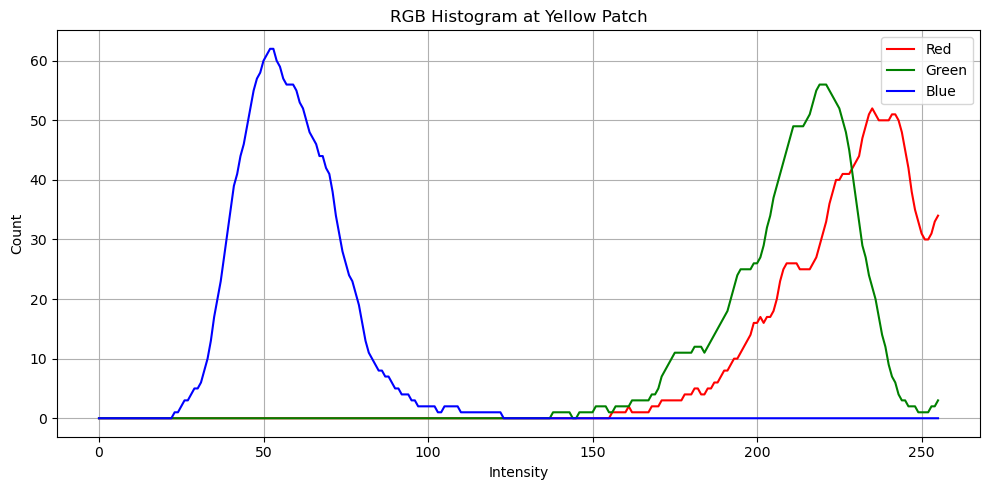

In [12]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

folder = "Images"
yellow = (80, 220)
reds, greens, blues = [], [], []

for filename in sorted(os.listdir(folder)):
    if filename.lower().endswith(('.jpg', '.png', '.jpeg')):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        if img is not None and img.shape[0] > yellow[1] and img.shape[1] > yellow[0]:
            b, g, r = img[yellow[1], yellow[0]]
            reds.append(r)
            greens.append(g)
            blues.append(b)

bins = np.arange(257)
r_hist, _ = np.histogram(reds, bins=bins)
g_hist, _ = np.histogram(greens, bins=bins)
b_hist, _ = np.histogram(blues, bins=bins)

r_smooth = gaussian_filter1d(r_hist, sigma=2)
g_smooth = gaussian_filter1d(g_hist, sigma=2)
b_smooth = gaussian_filter1d(b_hist, sigma=2)

plt.figure(figsize=(10, 5))
plt.plot(bins[:-1], r_smooth, 'r', label='Red')
plt.plot(bins[:-1], g_smooth, 'g', label='Green')
plt.plot(bins[:-1], b_smooth, 'b', label='Blue')
plt.title("RGB Histogram at Yellow Patch")
plt.xlabel("Intensity")
plt.ylabel("Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

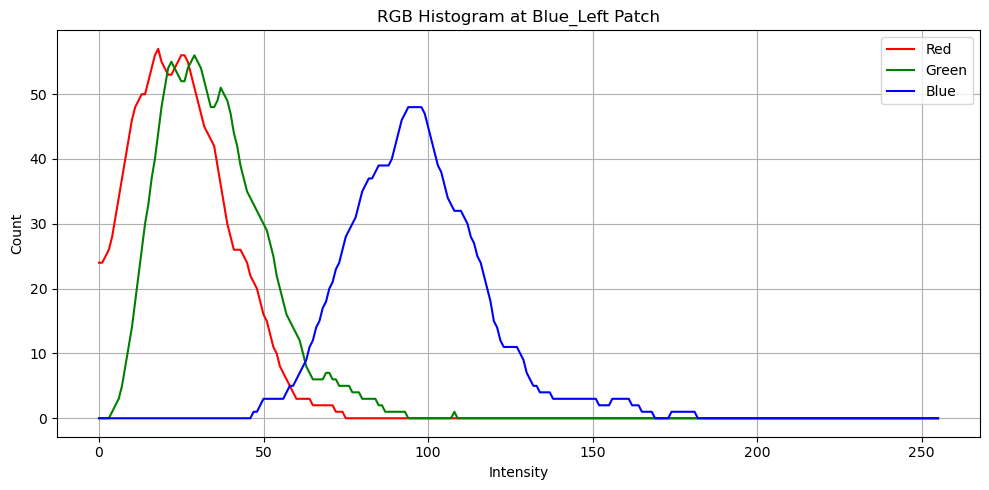

In [13]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

folder = "Images"
blue_left = (85, 370)
reds, greens, blues = [], [], []

for filename in sorted(os.listdir(folder)):
    if filename.lower().endswith(('.jpg', '.png', '.jpeg')):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        if img is not None and img.shape[0] > blue_left[1] and img.shape[1] > blue_left[0]:
            b, g, r = img[blue_left[1], blue_left[0]]
            reds.append(r)
            greens.append(g)
            blues.append(b)

bins = np.arange(257)
r_hist, _ = np.histogram(reds, bins=bins)
g_hist, _ = np.histogram(greens, bins=bins)
b_hist, _ = np.histogram(blues, bins=bins)

r_smooth = gaussian_filter1d(r_hist, sigma=2)
g_smooth = gaussian_filter1d(g_hist, sigma=2)
b_smooth = gaussian_filter1d(b_hist, sigma=2)

plt.figure(figsize=(10, 5))
plt.plot(bins[:-1], r_smooth, 'r', label='Red')
plt.plot(bins[:-1], g_smooth, 'g', label='Green')
plt.plot(bins[:-1], b_smooth, 'b', label='Blue')
plt.title("RGB Histogram at Blue_Left Patch")
plt.xlabel("Intensity")
plt.ylabel("Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

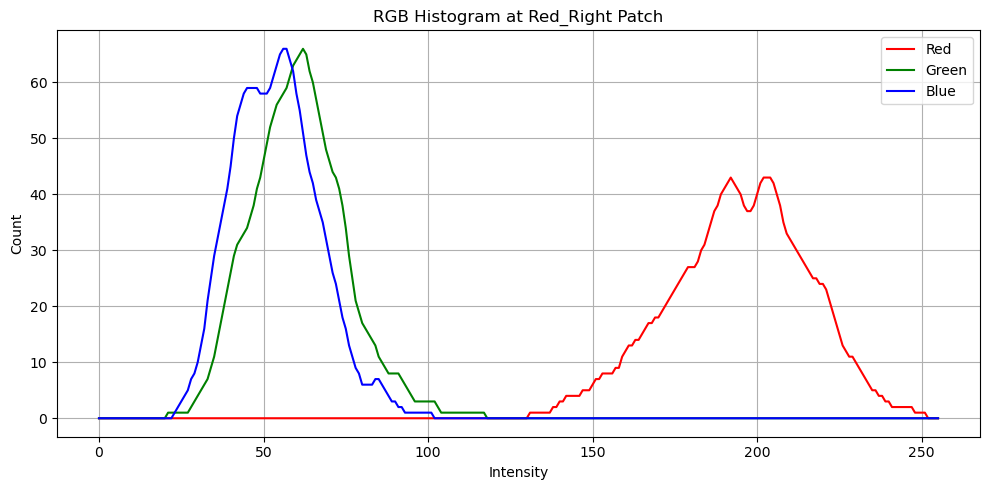

In [14]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

folder = "Images"
red_right = (500, 370)
reds, greens, blues = [], [], []

for filename in sorted(os.listdir(folder)):
    if filename.lower().endswith(('.jpg', '.png', '.jpeg')):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        if img is not None and img.shape[0] > red_right[1] and img.shape[1] > red_right[0]:
            b, g, r = img[red_right[1], red_right[0]]
            reds.append(r)
            greens.append(g)
            blues.append(b)

bins = np.arange(257)
r_hist, _ = np.histogram(reds, bins=bins)
g_hist, _ = np.histogram(greens, bins=bins)
b_hist, _ = np.histogram(blues, bins=bins)

r_smooth = gaussian_filter1d(r_hist, sigma=2)
g_smooth = gaussian_filter1d(g_hist, sigma=2)
b_smooth = gaussian_filter1d(b_hist, sigma=2)

plt.figure(figsize=(10, 5))
plt.plot(bins[:-1], r_smooth, 'r', label='Red')
plt.plot(bins[:-1], g_smooth, 'g', label='Green')
plt.plot(bins[:-1], b_smooth, 'b', label='Blue')
plt.title("RGB Histogram at Red_Right Patch")
plt.xlabel("Intensity")
plt.ylabel("Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

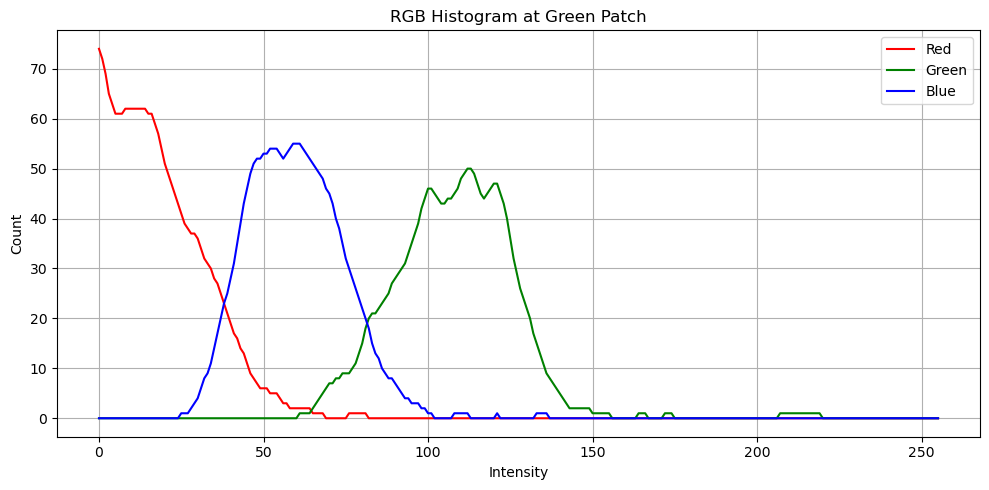

In [15]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

folder = "Images"
green = (350, 500)
reds, greens, blues = [], [], []

for filename in sorted(os.listdir(folder)):
    if filename.lower().endswith(('.jpg', '.png', '.jpeg')):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        if img is not None and img.shape[0] > green[1] and img.shape[1] > green[0]:
            b, g, r = img[green[1], green[0]]
            reds.append(r)
            greens.append(g)
            blues.append(b)

bins = np.arange(257)
r_hist, _ = np.histogram(reds, bins=bins)
g_hist, _ = np.histogram(greens, bins=bins)
b_hist, _ = np.histogram(blues, bins=bins)

r_smooth = gaussian_filter1d(r_hist, sigma=2)
g_smooth = gaussian_filter1d(g_hist, sigma=2)
b_smooth = gaussian_filter1d(b_hist, sigma=2)

plt.figure(figsize=(10, 5))
plt.plot(bins[:-1], r_smooth, 'r', label='Red')
plt.plot(bins[:-1], g_smooth, 'g', label='Green')
plt.plot(bins[:-1], b_smooth, 'b', label='Blue')
plt.title("RGB Histogram at Green Patch")
plt.xlabel("Intensity")
plt.ylabel("Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

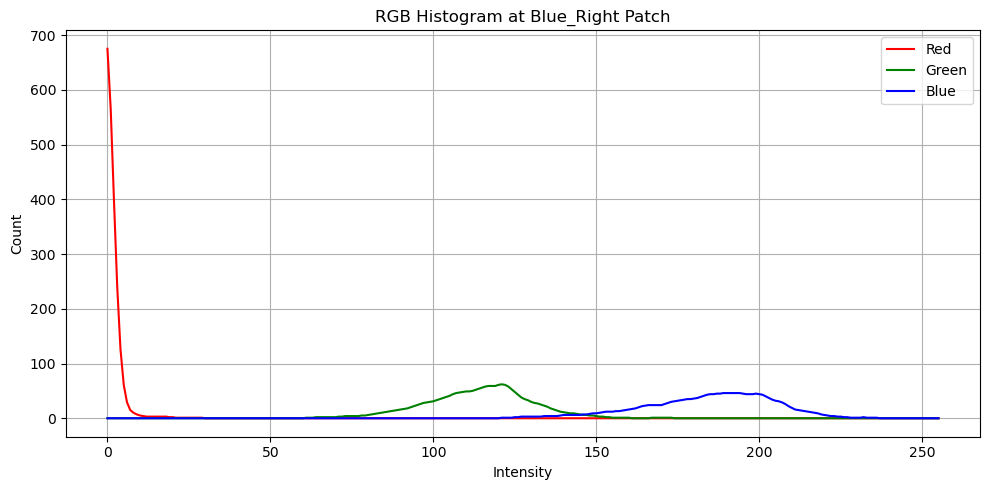

In [16]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

folder = "Images"
blue_right = (500, 220)
reds, greens, blues = [], [], []

for filename in sorted(os.listdir(folder)):
    if filename.lower().endswith(('.jpg', '.png', '.jpeg')):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        if img is not None and img.shape[0] > blue_right[1] and img.shape[1] > blue_right[0]:
            b, g, r = img[blue_right[1], blue_right[0]]
            reds.append(r)
            greens.append(g)
            blues.append(b)

bins = np.arange(257)
r_hist, _ = np.histogram(reds, bins=bins)
g_hist, _ = np.histogram(greens, bins=bins)
b_hist, _ = np.histogram(blues, bins=bins)

r_smooth = gaussian_filter1d(r_hist, sigma=2)
g_smooth = gaussian_filter1d(g_hist, sigma=2)
b_smooth = gaussian_filter1d(b_hist, sigma=2)

plt.figure(figsize=(10, 5))
plt.plot(bins[:-1], r_smooth, 'r', label='Red')
plt.plot(bins[:-1], g_smooth, 'g', label='Green')
plt.plot(bins[:-1], b_smooth, 'b', label='Blue')
plt.title("RGB Histogram at Blue_Right Patch")
plt.xlabel("Intensity")
plt.ylabel("Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

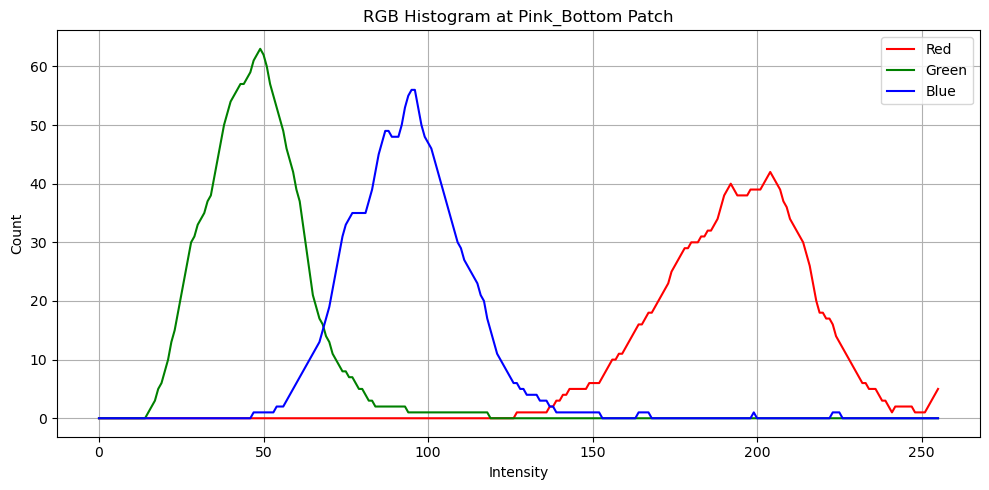

In [17]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

folder = "Images"
pink_bottom = (200, 500)
reds, greens, blues = [], [], []

for filename in sorted(os.listdir(folder)):
    if filename.lower().endswith(('.jpg', '.png', '.jpeg')):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        if img is not None and img.shape[0] > pink_bottom[1] and img.shape[1] > pink_bottom[0]:
            b, g, r = img[pink_bottom[1], pink_bottom[0]]
            reds.append(r)
            greens.append(g)
            blues.append(b)

bins = np.arange(257)
r_hist, _ = np.histogram(reds, bins=bins)
g_hist, _ = np.histogram(greens, bins=bins)
b_hist, _ = np.histogram(blues, bins=bins)

r_smooth = gaussian_filter1d(r_hist, sigma=2)
g_smooth = gaussian_filter1d(g_hist, sigma=2)
b_smooth = gaussian_filter1d(b_hist, sigma=2)

plt.figure(figsize=(10, 5))
plt.plot(bins[:-1], r_smooth, 'r', label='Red')
plt.plot(bins[:-1], g_smooth, 'g', label='Green')
plt.plot(bins[:-1], b_smooth, 'b', label='Blue')
plt.title("RGB Histogram at Pink_Bottom Patch")
plt.xlabel("Intensity")
plt.ylabel("Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# PREPROCESSING

## Colour Correction

In [18]:
import cv2
import numpy as np
import os

def color_correct_image(image_path, yellow_lower_hsv, yellow_upper_hsv, max_correction_factor=1.1):
    try:
        img = cv2.imread(image_path)
        if img is None:
            print(f"Error: Could not read image {image_path}. Skipping.")
            return None
        
        hsv_image = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        mask = cv2.inRange(hsv_image, yellow_lower_hsv, yellow_upper_hsv)
        yellow_region = cv2.bitwise_and(hsv_image, hsv_image, mask=mask)
        yellow_region_bgr = cv2.cvtColor(yellow_region, cv2.COLOR_HSV2BGR)
        contours, _ = cv2.findContours(cv2.cvtColor(yellow_region_bgr, cv2.COLOR_BGR2GRAY), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if contours:
            largest_contour = max(contours, key=cv2.contourArea)
            x, y, w, h = cv2.boundingRect(largest_contour)
            yellow_card_region = img[y:y+h, x:x+w]
            lab_yellow_card = cv2.cvtColor(yellow_card_region, cv2.COLOR_BGR2LAB)
            average_lab = cv2.mean(lab_yellow_card)[:3]
            if any(v == 0 for v in average_lab):
                print(f"Error: Average LAB values are zero for {image_path}. Skipping.")
                return None
            
            lab_image = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
            l, a, b = cv2.split(lab_image)
            l_factor = min(average_lab[0] / 128.0, max_correction_factor)
            a_factor = min(average_lab[1] / 128.0, max_correction_factor)
            b_factor = min(average_lab[2] / 128.0, max_correction_factor)

            l = np.clip(l * l_factor, 0, 255).astype(np.uint8)
            a = np.clip(a * a_factor, 0, 255).astype(np.uint8)
            b = np.clip(b * b_factor, 0, 255).astype(np.uint8)
            corrected_lab_image = cv2.merge([l, a, b])
            corrected_image = cv2.cvtColor(corrected_lab_image, cv2.COLOR_LAB2BGR)
            return corrected_image
        else:
            print(f"Error: No yellow card found in {image_path}. Skipping.")
            return None
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None


def batch_color_correct(image_folder, output_folder, yellow_lower_hsv, yellow_upper_hsv, max_correction_factor=1.1):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    image_files = [f for f in os.listdir(image_folder) if os.path.isfile(os.path.join(image_folder, f))]

    print(f"Found {len(image_files)} images in {image_folder}.")
    for image_file in image_files:
        image_path = os.path.join(image_folder, image_file)
        corrected_image = color_correct_image(image_path, yellow_lower_hsv, yellow_upper_hsv, max_correction_factor)
        if corrected_image is not None:
            output_path = os.path.join(output_folder, image_file)
            cv2.imwrite(output_path, corrected_image)
            print(f"Saved corrected image to {output_path}")

    print("Batch color correction complete.")



if __name__ == "__main__":
    image_folder = "Images"
    output_folder = "Corrected_Images"
    yellow_lower_hsv = (20, 100, 100)
    yellow_upper_hsv = (30, 255, 255)
    max_correction_factor = 1.05 
    batch_color_correct(image_folder, output_folder, yellow_lower_hsv, yellow_upper_hsv, max_correction_factor)

Found 2235 images in Images.
Saved corrected image to Corrected_Images/rotated_image(0992-2).jpg
Saved corrected image to Corrected_Images/rotated_image(0368-1).jpg
Saved corrected image to Corrected_Images/rotated_image(0261-2).jpg
Saved corrected image to Corrected_Images/rotated_image(0530-2).jpg
Saved corrected image to Corrected_Images/rotated_image(1007-2).jpg
Saved corrected image to Corrected_Images/rotated_image(1107-2).jpg
Saved corrected image to Corrected_Images/rotated_image(0539-1).jpg
Saved corrected image to Corrected_Images/rotated_image(0315-1).jpg
Saved corrected image to Corrected_Images/rotated_image(0444-1).jpg
Saved corrected image to Corrected_Images/rotated_image(0347-3).jpg
Saved corrected image to Corrected_Images/rotated_image(0516-3).jpg
Saved corrected image to Corrected_Images/rotated_image(1021-3).jpg
Saved corrected image to Corrected_Images/rotated_image(0247-3).jpg
Saved corrected image to Corrected_Images/rotated_image(1296-3).jpg
Saved corrected ima

Saved corrected image to Corrected_Images/rotated_image(0280-2).jpg
Saved corrected image to Corrected_Images/rotated_image(1251-2).jpg
Saved corrected image to Corrected_Images/rotated_image(0037-2).jpg
Saved corrected image to Corrected_Images/rotated_image(1351-2).jpg
Saved corrected image to Corrected_Images/rotated_image(0137-2).jpg
Saved corrected image to Corrected_Images/rotated_image(1258-1).jpg
Saved corrected image to Corrected_Images/rotated_image(0973-2).jpg
Saved corrected image to Corrected_Images/rotated_image(0802-2).jpg
Saved corrected image to Corrected_Images/rotated_image(0902-2).jpg
Saved corrected image to Corrected_Images/rotated_image(0146-2).jpg
Saved corrected image to Corrected_Images/rotated_image(1320-2).jpg
Saved corrected image to Corrected_Images/rotated_image(1229-1).jpg
Saved corrected image to Corrected_Images/rotated_image(1097-2).jpg
Saved corrected image to Corrected_Images/rotated_image(1329-1).jpg
Saved corrected image to Corrected_Images/rotate

Saved corrected image to Corrected_Images/rotated_image(1182-1).jpg
Saved corrected image to Corrected_Images/rotated_image(0938-3).jpg
Saved corrected image to Corrected_Images/rotated_image(0963-2).jpg
Saved corrected image to Corrected_Images/rotated_image(0127-2).jpg
Saved corrected image to Corrected_Images/rotated_image(1341-2).jpg
Saved corrected image to Corrected_Images/rotated_image(1248-1).jpg
Saved corrected image to Corrected_Images/rotated_image(1348-1).jpg
Saved corrected image to Corrected_Images/rotated_image(0776-2).jpg
Saved corrected image to Corrected_Images/rotated_image(1241-2).jpg
Saved corrected image to Corrected_Images/rotated_image(0290-2).jpg
Saved corrected image to Corrected_Images/rotated_image(1195-2).jpg
Saved corrected image to Corrected_Images/rotated_image(1279-3).jpg
Saved corrected image to Corrected_Images/rotated_image(0144-2).jpg
Saved corrected image to Corrected_Images/rotated_image(1322-2).jpg
Saved corrected image to Corrected_Images/rotate

Saved corrected image to Corrected_Images/rotated_image(0705-3).jpg
Saved corrected image to Corrected_Images/rotated_image(1232-3).jpg
Saved corrected image to Corrected_Images/rotated_image(1085-3).jpg
Saved corrected image to Corrected_Images/rotated_image(1269-2).jpg
Saved corrected image to Corrected_Images/rotated_image(1332-3).jpg
Saved corrected image to Corrected_Images/rotated_image(0657-1).jpg
Saved corrected image to Corrected_Images/rotated_image(1185-3).jpg
Saved corrected image to Corrected_Images/rotated_image(0995-1).jpg
Saved corrected image to Corrected_Images/rotated_image(0565-3).jpg
Saved corrected image to Corrected_Images/rotated_image(0083-3).jpg
Saved corrected image to Corrected_Images/rotated_image(1100-1).jpg
Saved corrected image to Corrected_Images/rotated_image(1009-2).jpg
Saved corrected image to Corrected_Images/rotated_image(1152-3).jpg
Saved corrected image to Corrected_Images/rotated_image(0680-1).jpg
Saved corrected image to Corrected_Images/rotate

Saved corrected image to Corrected_Images/rotated_image(1255-3).jpg
Saved corrected image to Corrected_Images/rotated_image(0762-3).jpg
Saved corrected image to Corrected_Images/rotated_image(0033-3).jpg
Saved corrected image to Corrected_Images/rotated_image(0639-2).jpg
Saved corrected image to Corrected_Images/rotated_image(0384-3).jpg
Saved corrected image to Corrected_Images/rotated_image(0068-2).jpg
Saved corrected image to Corrected_Images/rotated_image(0662-3).jpg
Saved corrected image to Corrected_Images/rotated_image(0739-2).jpg
Saved corrected image to Corrected_Images/rotated_image(0161-1).jpg
Saved corrected image to Corrected_Images/rotated_image(1307-1).jpg
Saved corrected image to Corrected_Images/rotated_image(0825-1).jpg
Error: No yellow card found in Images/rotated_image(0877-3).jpg. Skipping.
Saved corrected image to Corrected_Images/rotated_image(0914-3).jpg
Saved corrected image to Corrected_Images/rotated_image(0946-1).jpg
Saved corrected image to Corrected_Images

Saved corrected image to Corrected_Images/rotated_image(0970-1).jpg
Saved corrected image to Corrected_Images/rotated_image(0979-2).jpg
Saved corrected image to Corrected_Images/rotated_image(1191-2).jpg
Saved corrected image to Corrected_Images/rotated_image(1098-1).jpg
Saved corrected image to Corrected_Images/rotated_image(1326-2).jpg
Saved corrected image to Corrected_Images/rotated_image(0611-2).jpg
Saved corrected image to Corrected_Images/rotated_image(0140-2).jpg
Saved corrected image to Corrected_Images/rotated_image(0718-1).jpg
Saved corrected image to Corrected_Images/rotated_image(1198-1).jpg
Saved corrected image to Corrected_Images/rotated_image(1091-2).jpg
Saved corrected image to Corrected_Images/rotated_image(0618-1).jpg
Saved corrected image to Corrected_Images/rotated_image(0149-1).jpg
Saved corrected image to Corrected_Images/rotated_image(1226-2).jpg
Saved corrected image to Corrected_Images/rotated_image(0040-2).jpg
Saved corrected image to Corrected_Images/rotate

Saved corrected image to Corrected_Images/rotated_image(1148-2).jpg
Saved corrected image to Corrected_Images/rotated_image(0275-3).jpg
Saved corrected image to Corrected_Images/rotated_image(0886-3).jpg
Saved corrected image to Corrected_Images/rotated_image(0986-3).jpg
Saved corrected image to Corrected_Images/rotated_image(1282-2).jpg
Saved corrected image to Corrected_Images/rotated_image(0459-3).jpg
Saved corrected image to Corrected_Images/rotated_image(0559-3).jpg
Saved corrected image to Corrected_Images/rotated_image(0353-2).jpg
Saved corrected image to Corrected_Images/rotated_image(0208-3).jpg
Saved corrected image to Corrected_Images/rotated_image(0998-3).jpg
Saved corrected image to Corrected_Images/rotated_image(0561-2).jpg
Saved corrected image to Corrected_Images/rotated_image(1056-2).jpg
Saved corrected image to Corrected_Images/rotated_image(0339-1).jpg
Saved corrected image to Corrected_Images/rotated_image(0087-2).jpg
Saved corrected image to Corrected_Images/rotate

Saved corrected image to Corrected_Images/rotated_image(0979-3).jpg
Saved corrected image to Corrected_Images/rotated_image(0848-1).jpg
Saved corrected image to Corrected_Images/rotated_image(0841-2).jpg
Saved corrected image to Corrected_Images/rotated_image(0948-1).jpg
Saved corrected image to Corrected_Images/rotated_image(1263-2).jpg
Saved corrected image to Corrected_Images/rotated_image(1338-3).jpg
Saved corrected image to Corrected_Images/rotated_image(0005-2).jpg
Saved corrected image to Corrected_Images/rotated_image(0654-2).jpg
Saved corrected image to Corrected_Images/rotated_image(1238-3).jpg
Saved corrected image to Corrected_Images/rotated_image(0835-1).jpg
Saved corrected image to Corrected_Images/rotated_image(0867-3).jpg
Saved corrected image to Corrected_Images/rotated_image(0729-2).jpg
Saved corrected image to Corrected_Images/rotated_image(0123-3).jpg
Saved corrected image to Corrected_Images/rotated_image(0672-3).jpg
Saved corrected image to Corrected_Images/rotate

Saved corrected image to Corrected_Images/rotated_image(0012-2).jpg
Saved corrected image to Corrected_Images/rotated_image(0618-3).jpg
Saved corrected image to Corrected_Images/rotated_image(1098-3).jpg
Saved corrected image to Corrected_Images/rotated_image(0643-2).jpg
Saved corrected image to Corrected_Images/rotated_image(0718-3).jpg
Saved corrected image to Corrected_Images/rotated_image(0970-3).jpg
Saved corrected image to Corrected_Images/rotated_image(0383-3).jpg
Saved corrected image to Corrected_Images/rotated_image(0589-2).jpg
Saved corrected image to Corrected_Images/rotated_image(0134-3).jpg
Saved corrected image to Corrected_Images/rotated_image(1209-2).jpg
Saved corrected image to Corrected_Images/rotated_image(0665-3).jpg
Saved corrected image to Corrected_Images/rotated_image(1300-1).jpg
Saved corrected image to Corrected_Images/rotated_image(0637-1).jpg
Saved corrected image to Corrected_Images/rotated_image(0066-1).jpg
Saved corrected image to Corrected_Images/rotate

Saved corrected image to Corrected_Images/rotated_image(1096-2).jpg
Saved corrected image to Corrected_Images/rotated_image(1328-1).jpg
Saved corrected image to Corrected_Images/rotated_image(1221-2).jpg
Saved corrected image to Corrected_Images/rotated_image(1196-2).jpg
Saved corrected image to Corrected_Images/rotated_image(0147-2).jpg
Saved corrected image to Corrected_Images/rotated_image(1321-2).jpg
Saved corrected image to Corrected_Images/rotated_image(1228-1).jpg
Saved corrected image to Corrected_Images/rotated_image(0576-2).jpg
Saved corrected image to Corrected_Images/rotated_image(1041-2).jpg
Saved corrected image to Corrected_Images/rotated_image(1148-1).jpg
Saved corrected image to Corrected_Images/rotated_image(0099-1).jpg
Saved corrected image to Corrected_Images/rotated_image(1048-1).jpg
Saved corrected image to Corrected_Images/rotated_image(1141-2).jpg
Saved corrected image to Corrected_Images/rotated_image(0450-3).jpg
Saved corrected image to Corrected_Images/rotate

Saved corrected image to Corrected_Images/rotated_image(1014-3).jpg
Saved corrected image to Corrected_Images/rotated_image(0694-3).jpg
Saved corrected image to Corrected_Images/rotated_image(0197-1).jpg
Saved corrected image to Corrected_Images/rotated_image(0578-2).jpg
Saved corrected image to Corrected_Images/rotated_image(0372-3).jpg
Saved corrected image to Corrected_Images/rotated_image(1114-3).jpg
Saved corrected image to Corrected_Images/rotated_image(1146-1).jpg
Saved corrected image to Corrected_Images/rotated_image(0471-1).jpg
Saved corrected image to Corrected_Images/rotated_image(0354-2).jpg
Saved corrected image to Corrected_Images/rotated_image(1285-2).jpg
Saved corrected image to Corrected_Images/rotated_image(1032-2).jpg
Saved corrected image to Corrected_Images/rotated_image(1169-3).jpg
Saved corrected image to Corrected_Images/rotated_image(0254-2).jpg
Saved corrected image to Corrected_Images/rotated_image(1058-1).jpg
Saved corrected image to Corrected_Images/rotate

Saved corrected image to Corrected_Images/rotated_image(0015-1).jpg
Saved corrected image to Corrected_Images/rotated_image(1273-1).jpg
Saved corrected image to Corrected_Images/rotated_image(0744-1).jpg
Saved corrected image to Corrected_Images/rotated_image(1221-3).jpg
Saved corrected image to Corrected_Images/rotated_image(1196-3).jpg
Saved corrected image to Corrected_Images/rotated_image(1321-3).jpg
Saved corrected image to Corrected_Images/rotated_image(0147-3).jpg
Saved corrected image to Corrected_Images/rotated_image(0115-1).jpg
Saved corrected image to Corrected_Images/rotated_image(0825-2).jpg
Saved corrected image to Corrected_Images/rotated_image(0068-1).jpg
Saved corrected image to Corrected_Images/rotated_image(0739-1).jpg
Saved corrected image to Corrected_Images/rotated_image(0161-2).jpg
Saved corrected image to Corrected_Images/rotated_image(1307-2).jpg
Saved corrected image to Corrected_Images/rotated_image(0730-2).jpg
Saved corrected image to Corrected_Images/rotate

Saved corrected image to Corrected_Images/rotated_image(1091-1).jpg
Saved corrected image to Corrected_Images/rotated_image(0618-2).jpg
Saved corrected image to Corrected_Images/rotated_image(0012-3).jpg
Saved corrected image to Corrected_Images/rotated_image(1274-3).jpg
Saved corrected image to Corrected_Images/rotated_image(0149-2).jpg
Saved corrected image to Corrected_Images/rotated_image(1226-1).jpg
Saved corrected image to Corrected_Images/rotated_image(0040-1).jpg
Saved corrected image to Corrected_Images/rotated_image(1191-1).jpg
Saved corrected image to Corrected_Images/rotated_image(1098-2).jpg
Saved corrected image to Corrected_Images/rotated_image(1326-1).jpg
Saved corrected image to Corrected_Images/rotated_image(0611-1).jpg
Saved corrected image to Corrected_Images/rotated_image(0140-1).jpg
Saved corrected image to Corrected_Images/rotated_image(0718-2).jpg
Saved corrected image to Corrected_Images/rotated_image(0643-3).jpg
Saved corrected image to Corrected_Images/rotate

Saved corrected image to Corrected_Images/rotated_image(0008-3).jpg
Saved corrected image to Corrected_Images/rotated_image(1335-2).jpg
Saved corrected image to Corrected_Images/rotated_image(0602-2).jpg
Saved corrected image to Corrected_Images/rotated_image(1182-2).jpg
Saved corrected image to Corrected_Images/rotated_image(0108-3).jpg
Saved corrected image to Corrected_Images/rotated_image(1235-2).jpg
Saved corrected image to Corrected_Images/rotated_image(0702-2).jpg
Saved corrected image to Corrected_Images/rotated_image(1082-2).jpg
Saved corrected image to Corrected_Images/rotated_image(1213-3).jpg
Saved corrected image to Corrected_Images/rotated_image(1348-2).jpg
Saved corrected image to Corrected_Images/rotated_image(0776-1).jpg
Saved corrected image to Corrected_Images/rotated_image(1241-1).jpg
Saved corrected image to Corrected_Images/rotated_image(0593-3).jpg
Saved corrected image to Corrected_Images/rotated_image(0290-1).jpg
Saved corrected image to Corrected_Images/rotate

Saved corrected image to Corrected_Images/rotated_image(1314-1).jpg
Saved corrected image to Corrected_Images/rotated_image(0964-3).jpg
Saved corrected image to Corrected_Images/rotated_image(0936-1).jpg
Saved corrected image to Corrected_Images/rotated_image(0864-3).jpg
Saved corrected image to Corrected_Images/rotated_image(1269-1).jpg
Saved corrected image to Corrected_Images/rotated_image(0657-2).jpg
Saved corrected image to Corrected_Images/rotated_image(1260-2).jpg
Saved corrected image to Corrected_Images/rotated_image(0006-2).jpg
Saved corrected image to Corrected_Images/rotated_image(0842-2).jpg
Saved corrected image to Corrected_Images/rotated_image(1332-1).jpg
Saved corrected image to Corrected_Images/rotated_image(0657-3).jpg
Saved corrected image to Corrected_Images/rotated_image(1185-1).jpg
Saved corrected image to Corrected_Images/rotated_image(0006-3).jpg
Saved corrected image to Corrected_Images/rotated_image(1260-3).jpg
Saved corrected image to Corrected_Images/rotate

Saved corrected image to Corrected_Images/rotated_image(1348-3).jpg
Saved corrected image to Corrected_Images/rotated_image(1213-2).jpg
Saved corrected image to Corrected_Images/rotated_image(0593-2).jpg
Saved corrected image to Corrected_Images/rotated_image(1248-3).jpg
Saved corrected image to Corrected_Images/rotated_image(1313-2).jpg
Saved corrected image to Corrected_Images/rotated_image(0931-2).jpg
Saved corrected image to Corrected_Images/rotated_image(0938-1).jpg
Saved corrected image to Corrected_Images/rotated_image(1335-3).jpg
Saved corrected image to Corrected_Images/rotated_image(0602-3).jpg
Saved corrected image to Corrected_Images/rotated_image(0008-2).jpg
Saved corrected image to Corrected_Images/rotated_image(0153-3).jpg
Saved corrected image to Corrected_Images/rotated_image(0101-1).jpg
Saved corrected image to Corrected_Images/rotated_image(0650-1).jpg
Saved corrected image to Corrected_Images/rotated_image(1182-3).jpg
Saved corrected image to Corrected_Images/rotate

Saved corrected image to Corrected_Images/rotated_image(1298-1).jpg
Saved corrected image to Corrected_Images/rotated_image(1100-3).jpg
Saved corrected image to Corrected_Images/rotated_image(1152-1).jpg
Saved corrected image to Corrected_Images/rotated_image(0680-3).jpg
Saved corrected image to Corrected_Images/rotated_image(0183-1).jpg
Saved corrected image to Corrected_Images/rotated_image(0565-1).jpg
Saved corrected image to Corrected_Images/rotated_image(0083-1).jpg
Saved corrected image to Corrected_Images/rotated_image(0995-3).jpg
Batch color correction complete.


## Cropping

In [19]:
import cv2
import os

def crop_skin_from_color_card(image_paths, output_dir='Cropped_Skin'):
    os.makedirs(output_dir, exist_ok=True)  
    for image_path in image_paths:
        try:
            img = cv2.imread(image_path)
            if img is None:
                print(f"Error: Could not read image at {image_path}")
                continue 
                
            height, width, _ = img.shape
            start_x = int(width * 0.35)
            end_x = int(width * 0.68)
            start_y = int(height * 0.35)
            end_y = int(height * 0.67)
            cropped_skin = img[start_y:end_y, start_x:end_x]
            original_filename = os.path.basename(image_path)  
            original_base_name = os.path.splitext(original_filename)[0] 
            output_filename = f"{original_base_name}_cropped_skin.jpg"
            output_path = os.path.join(output_dir, output_filename)
            cv2.imwrite(output_path, cropped_skin)
            print(f"Cropped skin saved to: {output_path}")

        except Exception as e:
            print(f"An error occurred while processing {image_path}: {e}")

    print(f"Successfully cropped and saved skin patches.")


if __name__ == "__main__":
    input_folder = 'Images'
    output_folder = 'Cropped_Skin'
    image_files = [
        os.path.join(input_folder, f)
        for f in os.listdir(input_folder)
        if os.path.isfile(os.path.join(input_folder, f))
    ]
    crop_skin_from_color_card(image_files, output_folder)

Cropped skin saved to: Cropped_Skin/rotated_image(0992-2)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(0368-1)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(0261-2)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(0530-2)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(1007-2)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(1107-2)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(0539-1)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(0315-1)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(0444-1)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(0347-3)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(0516-3)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(1021-3)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(0247-3)_cropped_skin.jpg
Cropped skin saved to: Cr

Cropped skin saved to: Cropped_Skin/rotated_image(0764-3)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(1253-3)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(0588-2)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(1208-2)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(0135-3)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(1301-1)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(0167-1)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(1099-3)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(0113-2)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(0742-2)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(1275-2)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(0148-3)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(0013-2)_cropped_skin.jpg
Cropped skin saved to: Cr

Cropped skin saved to: Cropped_Skin/rotated_image(0056-2)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(1330-2)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(0156-2)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(1239-1)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(0812-2)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(0949-3)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(0673-1)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(1344-1)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(0122-1)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(1316-3)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(0395-1)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(1244-1)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(0022-1)_cropped_skin.jpg
Cropped skin saved to: Cr

Cropped skin saved to: Cropped_Skin/rotated_image(0257-3)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(1031-3)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(0554-1)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(1063-1)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(0305-1)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(0987-1)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(0692-1)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(0191-3)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(0374-1)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(1112-1)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(0477-3)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(1140-3)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(0792-1)_cropped_skin.jpg
Cropped skin saved to: Cr

Cropped skin saved to: Cropped_Skin/rotated_image(0639-2)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(0384-3)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(0068-2)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(0662-3)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(0739-2)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(0161-1)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(1307-1)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(0825-1)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(0877-3)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(0914-3)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(0946-1)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(0002-1)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(1264-1)_cropped_skin.jpg
Cropped skin saved to: Cr

Cropped skin saved to: Cropped_Skin/rotated_image(1252-1)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(0383-1)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(0665-1)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(0134-1)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(1300-3)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(0637-3)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(0970-1)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(0979-2)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(1191-2)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(1098-1)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(1326-2)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(0611-2)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(0140-2)_cropped_skin.jpg
Cropped skin saved to: Cr

Cropped skin saved to: Cropped_Skin/rotated_image(1179-1)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(0547-2)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(1070-2)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(0998-2)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(0561-3)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(1056-3)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(0262-1)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(1004-1)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(0087-3)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(1104-1)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(1156-3)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(0330-3)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(0187-3)_cropped_skin.jpg
Cropped skin saved to: Cr

Cropped skin saved to: Cropped_Skin/rotated_image(1111-2)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(1018-1)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(0277-2)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(1011-2)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(1029-3)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(0445-2)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(0214-2)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(0531-1)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(1006-1)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(0786-1)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(1106-1)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(1154-3)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(0463-3)_cropped_skin.jpg
Cropped skin saved to: Cr

Cropped skin saved to: Cropped_Skin/rotated_image(1305-1)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(0972-1)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(0920-3)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(0872-1)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(0582-3)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(0281-1)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(1202-3)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(1250-1)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(0767-1)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(0381-1)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(1350-1)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(0667-1)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(1259-2)_cropped_skin.jpg
Cropped skin saved to: Cr

Cropped skin saved to: Cropped_Skin/rotated_image(0729-1)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(0078-1)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(1317-2)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(0497-2)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(0835-2)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(0009-1)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(0100-2)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(1266-2)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(0109-1)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(0939-2)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(1212-1)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(0725-1)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(1240-3)_cropped_skin.jpg
Cropped skin saved to: Cr

Cropped skin saved to: Cropped_Skin/rotated_image(1096-2)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(1328-1)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(1221-2)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(1196-2)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(0147-2)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(1321-2)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(1228-1)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(0576-2)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(1041-2)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(1148-1)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(0099-1)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(1048-1)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(1141-2)_cropped_skin.jpg
Cropped skin saved to: Cr

Cropped skin saved to: Cropped_Skin/rotated_image(1030-3)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(0555-1)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(1062-1)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(0796-2)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(1016-2)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(0696-2)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(1116-2)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(0421-2)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(0370-2)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(0279-1)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(0983-2)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(0542-2)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(0248-3)_cropped_skin.jpg
Cropped skin saved to: Cr

Cropped skin saved to: Cropped_Skin/rotated_image(0497-3)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(0835-3)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(0867-1)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(1238-1)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(1186-2)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(1338-1)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(0057-2)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(0948-3)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(0848-3)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(0979-1)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(0970-2)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(0589-3)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(0383-2)_cropped_skin.jpg
Cropped skin saved to: Cr

Cropped skin saved to: Cropped_Skin/rotated_image(0139-1)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(0668-1)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(0761-2)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(0148-1)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(1227-2)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(1190-2)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(1099-1)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(1327-2)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(0141-2)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(0135-1)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(0167-3)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(1301-3)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(0282-1)_cropped_skin.jpg
Cropped skin saved to: Cr

Cropped skin saved to: Cropped_Skin/rotated_image(0949-1)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(0940-2)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(0104-2)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(1239-3)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(1262-2)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(1339-3)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(0588-1)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(1208-1)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(1301-2)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(0167-2)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(0736-2)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(1308-1)_cropped_skin.jpg
Cropped skin saved to: Cropped_Skin/rotated_image(0823-2)_cropped_skin.jpg
Cropped skin saved to: Cr

# Model

In [1]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

img_folder = 'Cropped_Skin'
img_size = (224, 224)
X_img = []
for filename in sorted(os.listdir(img_folder)):
    if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
        img_path = os.path.join(img_folder, filename)
        img = load_img(img_path, target_size=img_size)
        img_array = img_to_array(img)
        img_array = preprocess_input(img_array)
        X_img.append(img_array)

X_img = np.array(X_img)
print("Loaded images:", X_img.shape)

Loaded images: (2235, 224, 224, 3)


In [2]:
# Load MobileNetV2 for feature extraction
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
feature_extractor = Model(inputs=base_model.input, outputs=base_model.output)
features = feature_extractor.predict(X_img, verbose=1)
features_flat = features.reshape(features.shape[0], -1)

70/70 [==============================] - 17s 232ms/step


In [3]:
kmeans = KMeans(n_clusters=2, random_state=42)
pseudo_labels = kmeans.fit_predict(features_flat)
y_labels = to_categorical(pseudo_labels)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X_img, y_labels, test_size=0.2, random_state=42)
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dense(2, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)

Epoch 1/10
56/56 [==============================] - 84s 1s/step - loss: 0.3817 - accuracy: 0.8216 - val_loss: 0.9935 - val_accuracy: 0.7383
Epoch 2/10
56/56 [==============================] - 77s 1s/step - loss: 0.1420 - accuracy: 0.9430 - val_loss: 1.4662 - val_accuracy: 0.7226
Epoch 3/10
56/56 [==============================] - 79s 1s/step - loss: 0.0801 - accuracy: 0.9709 - val_loss: 1.1549 - val_accuracy: 0.7338
Epoch 4/10
56/56 [==============================] - 79s 1s/step - loss: 0.0497 - accuracy: 0.9843 - val_loss: 1.5874 - val_accuracy: 0.7248
Epoch 5/10
56/56 [==============================] - 73s 1s/step - loss: 0.0363 - accuracy: 0.9877 - val_loss: 1.8199 - val_accuracy: 0.7181
Epoch 6/10
56/56 [==============================] - 84s 2s/step - loss: 0.0286 - accuracy: 0.9933 - val_loss: 1.3633 - val_accuracy: 0.7360
Epoch 7/10
56/56 [==============================] - 96s 2s/step - loss: 0.0240 - accuracy: 0.9938 - val_loss: 2.3930 - val_accuracy: 0.7338
Epoch 8/10
56/56 [==

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 2422210 (9.24 MB)
Trainable params: 2388098 (9.11 MB)
Non-trainable params: 34112 (133.25 KB)
_________________________________________________________________


In [5]:
train_acc = model.evaluate(X_train, y_train, verbose=0)[1] * 100
test_acc = model.evaluate(X_test, y_test, verbose=0)[1] * 100

print(f" Training Accuracy: {train_acc:.2f}%")
print(f" Testing Accuracy: {test_acc:.2f}%")

 Training Accuracy: 76.57%
 Testing Accuracy: 78.30%


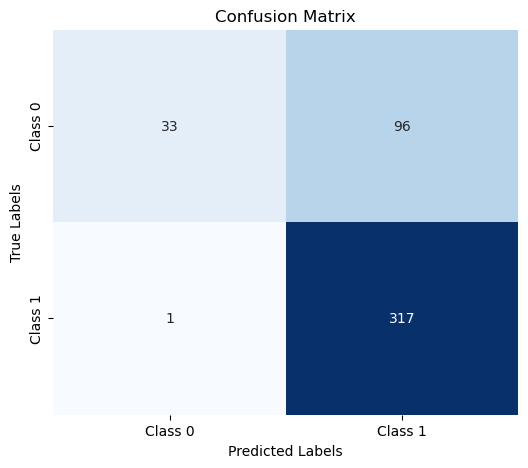

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

#Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Class 0', 'Class 1'],
            yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [11]:
from sklearn.metrics import confusion_matrix, classification_report
y_pred_probs = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test, axis=1)
report = classification_report(y_true_classes, y_pred_classes, target_names=["Class 0", "Class 1"])
print("\nClassification Report:\n", report)


14/14 [==============================] - 3s 195ms/step

Classification Report:
               precision    recall  f1-score   support

     Class 0       0.97      0.26      0.40       129
     Class 1       0.77      1.00      0.87       318

    accuracy                           0.78       447
   macro avg       0.87      0.63      0.64       447
weighted avg       0.83      0.78      0.73       447



In [19]:
#Unfreeze the last few layers
base_model.trainable = True
for layer in base_model.layers[:-30]:  #Freezing all, but last 30 layers
    layer.trainable = False
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=32, callbacks=[early_stop], verbose=1)


Epoch 1/10
45/45 [==============================] - 15s 284ms/step - loss: 0.6752 - accuracy: 0.7175 - val_loss: 0.3591 - val_accuracy: 0.8240
Epoch 2/10
45/45 [==============================] - 14s 320ms/step - loss: 0.5044 - accuracy: 0.7923 - val_loss: 0.3373 - val_accuracy: 0.8436
Epoch 3/10
45/45 [==============================] - 13s 297ms/step - loss: 0.4039 - accuracy: 0.8224 - val_loss: 0.3482 - val_accuracy: 0.8296
Epoch 4/10
45/45 [==============================] - 12s 271ms/step - loss: 0.3683 - accuracy: 0.8441 - val_loss: 0.3571 - val_accuracy: 0.8240
Epoch 5/10
45/45 [==============================] - 12s 276ms/step - loss: 0.3285 - accuracy: 0.8531 - val_loss: 0.4177 - val_accuracy: 0.8128
Epoch 6/10
45/45 [==============================] - 13s 294ms/step - loss: 0.2989 - accuracy: 0.8615 - val_loss: 0.4520 - val_accuracy: 0.7989
Epoch 7/10
45/45 [==============================] - 13s 286ms/step - loss: 0.2908 - accuracy: 0.8734 - val_loss: 0.4954 - val_accuracy: 0.7709

# CNN

In [25]:
import os
import numpy as np
import cv2
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

def load_images(folder, img_size=(128, 128)):
    X = []
    for file in sorted(os.listdir(folder)):
        if file.lower().endswith(('.jpg', '.png', '.jpeg')):
            path = os.path.join(folder, file)
            img = cv2.imread(path)
            img = cv2.resize(img, img_size)
            img = img.astype(np.float32) / 255.0
            X.append(img)
    return np.array(X)

X_img = load_images("Cropped_Skin")
print(" Images loaded:", X_img.shape)
X_flat = X_img.reshape((X_img.shape[0], -1))
kmeans = KMeans(n_clusters=2, random_state=42)
y_clusters = kmeans.fit_predict(X_flat)
y_binary = np.array([1 if c == 1 else 0 for c in y_clusters])
y_binary_cat = to_categorical(y_binary)
X_train, X_test, y_train, y_test = train_test_split(X_img, y_binary_cat, test_size=0.2, random_state=42)

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(2, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stop], verbose=1)
train_acc = model.evaluate(X_train, y_train, verbose=0)[1] * 100
test_acc = model.evaluate(X_test, y_test, verbose=0)[1] * 100
print(f"\n Training Accuracy (CNN): {train_acc:.2f}%")
print(f" Testing Accuracy (CNN): {test_acc:.2f}%")

model.summary()

 Images loaded: (2235, 128, 128, 3)


Epoch 1/50
45/45 [==============================] - 7s 148ms/step - loss: 0.6815 - accuracy: 0.5762 - val_loss: 0.6130 - val_accuracy: 0.9441
Epoch 2/50
45/45 [==============================] - 7s 147ms/step - loss: 0.5692 - accuracy: 0.6979 - val_loss: 0.5175 - val_accuracy: 0.7207
Epoch 3/50
45/45 [==============================] - 7s 149ms/step - loss: 0.4008 - accuracy: 0.8140 - val_loss: 0.2576 - val_accuracy: 0.8966
Epoch 4/50
45/45 [==============================] - 7s 153ms/step - loss: 0.2700 - accuracy: 0.8783 - val_loss: 0.2014 - val_accuracy: 0.9302
Epoch 5/50
45/45 [==============================] - 7s 156ms/step - loss: 0.2169 - accuracy: 0.9084 - val_loss: 0.1682 - val_accuracy: 0.9330
Epoch 6/50
45/45 [==============================] - 7s 163ms/step - loss: 0.2030 - accuracy: 0.9063 - val_loss: 0.1447 - val_accuracy: 0.9581
Epoch 7/50
45/45 [==============================] - 7s 150ms/step - loss: 0.2517 - accuracy: 0.8979 - val_loss: 0.1600 - val_accuracy: 0.9553
Epoch 

# Save

In [26]:
model.save("cnn_jaundice_classifier_96acc.h5")

/Users/adrianfernandes/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Training vs Validation Loss

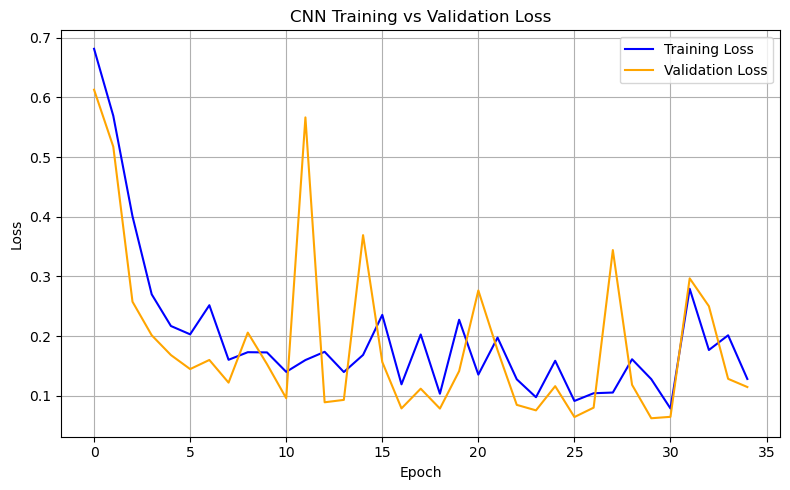

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title("CNN Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Confusion Matrix

14/14 [==============================] - 1s 39ms/step


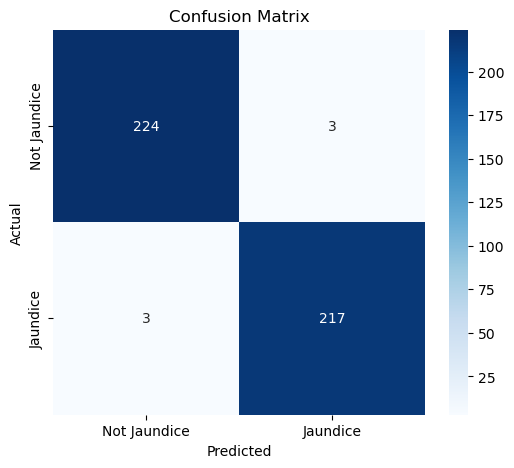


 Classification Report:
              precision    recall  f1-score   support

Not Jaundice       0.99      0.99      0.99       227
    Jaundice       0.99      0.99      0.99       220

    accuracy                           0.99       447
   macro avg       0.99      0.99      0.99       447
weighted avg       0.99      0.99      0.99       447



In [28]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)
labels = ["Not Jaundice", "Jaundice"]

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("\n Classification Report:")
print(classification_report(y_true, y_pred, target_names=labels))

In [29]:
report = classification_report(y_true, y_pred, target_names=labels, output_dict=True)

print("\n Classification Report:")
print("Precision, Recall, F1 Score for each class:")
print(f"Jaundice - Precision: {report['Jaundice']['precision']:.2f}, Recall: {report['Jaundice']['recall']:.2f}, F1 Score: {report['Jaundice']['f1-score']:.2f}")
print(f"Not Jaundice - Precision: {report['Not Jaundice']['precision']:.2f}, Recall: {report['Not Jaundice']['recall']:.2f}, F1 Score: {report['Not Jaundice']['f1-score']:.2f}")


 Classification Report:
Precision, Recall, F1 Score for each class:
Jaundice - Precision: 0.99, Recall: 0.99, F1 Score: 0.99
Not Jaundice - Precision: 0.99, Recall: 0.99, F1 Score: 0.99


# Classifying

### Cropped Images

In [13]:
import os
import cv2
import numpy as np

image_folder = "Cropped_Skin"
img_size = (128, 128)
predictions = []

for filename in sorted(os.listdir(image_folder)):
    if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
        img_path = os.path.join(image_folder, filename)
        img = cv2.imread(img_path)
        img = cv2.resize(img, img_size)
        img = img.astype(np.float32) / 255.0
        img = np.expand_dims(img, axis=0)  

        pred = model.predict(img)
        class_id = np.argmax(pred)
        label = "Jaundice" if class_id == 1 else "Not Jaundice"
        predictions.append((filename, label))

print("\n Jaundice Classification Results:")
for fname, label in predictions:
    print(f"{fname}: {label}")

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step

📋 Jaundice Classification Results:
rotated_image(0001-1)_cropped_skin.jpg: Jaundice
rotated_image(0001-2)_cropped_skin.jpg: Jaundice
rotated_image(0001-3)_cropped_skin.jpg: Jaundice
rotated_image(0002-1)_cropped_skin.jpg: Not Jaundice
rotated_image(0002-2)_cropped_skin.jpg: Jaundice
rotated_image(0002-3)_cropped_skin.jpg: Jaundice
rotated_image(0003-1)_cropped_skin.jpg: Not Jaundice
rotated_image(0003-2)_cropped_skin.jpg: Jaundice
rotated_image(0003-3)_cropped_skin.jpg: Jaundice
rotated_image(0005-1)_cropped_skin.jpg: Not Jaundice
rotated_image(0005-2)_cropped_skin.jpg: Jaundice
rotated_image(0005-3)_cropped_skin.jpg: Jaundice
rotated_image(0006-1)_cropped_skin.jpg: Not Jaundice
rotated_image(0006-2)_cropped_skin.jpg: Not Jaundice
rotated_image(0006-3)_cropped_skin.jpg: Jaundice
rotated_image(0008-1)_cropped_skin.jpg: Not Jaundice
rotated_image(0008-2)_cropped_skin.jpg: Jaundice
rotated_image(0008-3)_cropped_skin.jpg: Jaundice
rotate

### Corrected Images

In [10]:
import os
import cv2
import numpy as np

image_folder = "Corrected_Images"
img_size = (128, 128)
predictions = []

for filename in sorted(os.listdir(image_folder)):
    if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
        img_path = os.path.join(image_folder, filename)
        img = cv2.imread(img_path)
        img = cv2.resize(img, img_size)
        img = img.astype(np.float32) / 255.0
        img = np.expand_dims(img, axis=0)  

        pred = model.predict(img)
        class_id = np.argmax(pred)
        label = "Jaundice" if class_id == 1 else "Not Jaundice"
        predictions.append((filename, label))

print("\n Jaundice Classification Results:")
for fname, label in predictions:
    print(f"{fname}: {label}")

1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step

📋 Jaundice Classification Results:
rotated_image(0001-1).jpg: Not Jaundice
rotated_image(0001-2).jpg: Jaundice
rotated_image(0001-3).jpg: Not Jaundice
rotated_image(0002-1).jpg: Not Jaundice
rotated_image(0002-2).jpg: Jaundice
rotated_image(0002-3).jpg: Not Jaundice
rotated_image(0003-1).jpg: Not Jaundice
rotated_image(0003-2).jpg: Not Jaundice
rotated_image(0003-3).jpg: Not Jaundice
rotated_image(0005-1).jpg: Not Jaundice
rotated_image(0005-2).jpg: Not Jaundice
rotated_image(0005-3).jpg: Not Jaundice
rotated_image(0006-1).jpg: Not Jaundice
rotated_image(0006-2).jpg: Not Jaundice
rotated_image(0006-3).jpg: Not Jaundice
rotated_image(0008-1).jpg: Not Jaundice
rotated_image(0008-2).jpg: Not Jaundice
rotated_image(0008-3).jpg: Not Jaundice
rotated_image(0009-1).jpg: Not Jaundice
rotated_image(0009-2).jpg: Not Jaundice
rotated_image(0009-3).jpg: Not Jaundice
rotated_image(0010-1).jpg: Not Jaundice
rotated_image(0010-2).jpg: Not Jaundice
r

### Without Preprocessing

In [15]:
import os
import cv2
import numpy as np

image_folder = "Images"
img_size = (128, 128)
predictions = []

for filename in sorted(os.listdir(image_folder)):
    if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
        img_path = os.path.join(image_folder, filename)
        img = cv2.imread(img_path)
        img = cv2.resize(img, img_size)
        img = img.astype(np.float32) / 255.0
        img = np.expand_dims(img, axis=0) 

        pred = model.predict(img)
        class_id = np.argmax(pred)
        label = "Jaundice" if class_id == 1 else "Not Jaundice"
        predictions.append((filename, label))

print("\n Jaundice Classification Results:")
for fname, label in predictions:
    print(f"{fname}: {label}")

1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step

📋 Jaundice Classification Results:
rotated_image(0001-1).jpg: Not Jaundice
rotated_image(0001-2).jpg: Not Jaundice
rotated_image(0001-3).jpg: Not Jaundice
rotated_image(0002-1).jpg: Not Jaundice
rotated_image(0002-2).jpg: Jaundice
rotated_image(0002-3).jpg: Not Jaundice
rotated_image(0003-1).jpg: Not Jaundice
rotated_image(0003-2).jpg: Not Jaundice
rotated_image(0003-3).jpg: Not Jaundice
rotated_image(0005-1).jpg: Not Jaundice
rotated_image(0005-2).jpg: Not Jaundice
rotated_image(0005-3).jpg: Not Jaundice
rotated_image(0006-1).jpg: Not Jaundice
rotated_image(0006-2).jpg: Not Jaundice
rotated_image(0006-3).jpg: Not Jaundice
rotated_image(0008-1).jpg: Not Jaundice
rotated_image(0008-2).jpg: Not Jaundice
rotated_image(0008-3).jpg: Not Jaundice
rotated_image(0009-1).jpg: Not Jaundice
rotated_image(0009-2).jpg: Not Jaundice
rotated_image(0009-3).jpg: Not Jaundice
rotated_image(0010-1).jpg: Not Jaundice
rotated_image(0010-2).jpg: Not Jaundi

# CSV

### Cropped Images

In [11]:
import os
import cv2
import numpy as np
import pandas as pd

image_folder = "Cropped_Skin"
img_size = (128, 128)
predictions = []

for filename in sorted(os.listdir(image_folder)):
    if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
        img_path = os.path.join(image_folder, filename)
        img = cv2.imread(img_path)
        img = cv2.resize(img, img_size)
        img = img.astype(np.float32) / 255.0
        img = np.expand_dims(img, axis=0)  

        pred = model.predict(img)
        class_id = np.argmax(pred)
        label = "Jaundice" if class_id == 1 else "Not Jaundice"
        predictions.append([filename, label])

df_preds = pd.DataFrame(predictions, columns=["Filename", "Prediction"])
df_preds.to_csv("jaundice_predictions_Cropped_Skin.csv", index=False)

print("\n Predictions saved to 'jaundice_predictions_Cropped_Skin.csv'")

1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step

✅ Predictions saved to 'jaundice_predictions_Cropped_Skin.csv'


### Corrected Images

In [14]:
import os
import cv2
import numpy as np
import pandas as pd

image_folder = "Corrected_Images"
img_size = (128, 128)
predictions = []

for filename in sorted(os.listdir(image_folder)):
    if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
        img_path = os.path.join(image_folder, filename)
        img = cv2.imread(img_path)
        img = cv2.resize(img, img_size)
        img = img.astype(np.float32) / 255.0
        img = np.expand_dims(img, axis=0)  

        pred = model.predict(img)
        class_id = np.argmax(pred)
        label = "Jaundice" if class_id == 1 else "Not Jaundice"
        predictions.append([filename, label])

df_preds = pd.DataFrame(predictions, columns=["Filename", "Prediction"])
df_preds.to_csv("jaundice_predictions_Corrected_Images.csv", index=False)

print("\n Predictions saved to 'jaundice_predictions_Corrected_Images.csv'")

1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 10ms/step

✅ Predictions saved to 'jaundice_predictions_Corrected_Images.csv'


### Without Preprocessing

In [16]:
import os
import cv2
import numpy as np
import pandas as pd

image_folder = "Images"
img_size = (128, 128)
predictions = []

for filename in sorted(os.listdir(image_folder)):
    if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
        img_path = os.path.join(image_folder, filename)
        img = cv2.imread(img_path)
        img = cv2.resize(img, img_size)
        img = img.astype(np.float32) / 255.0
        img = np.expand_dims(img, axis=0) 

        pred = model.predict(img)
        class_id = np.argmax(pred)
        label = "Jaundice" if class_id == 1 else "Not Jaundice"
        predictions.append([filename, label])

df_preds = pd.DataFrame(predictions, columns=["Filename", "Prediction"])
df_preds.to_csv("jaundice_predictions_Images.csv", index=False)

print("\n Predictions saved to 'jaundice_predictions_Images.csv'")

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step

✅ Predictions saved to 'jaundice_predictions_Images.csv'


# K-Fold Cross Validation

In [12]:
import os
import cv2
import numpy as np
from sklearn.model_selection import KFold
from sklearn.cluster import KMeans
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def load_images(folder, img_size=(128, 128)):
    X = []
    for file in sorted(os.listdir(folder)):
        if file.lower().endswith(('.jpg', '.png', '.jpeg')):
            path = os.path.join(folder, file)
            img = cv2.imread(path)
            img = cv2.resize(img, img_size)
            img = img.astype(np.float32) / 255.0
            X.append(img)
    return np.array(X)

X = load_images("Cropped_Skin")
print(" Total images loaded:", len(X))

X_flat = X.reshape(X.shape[0], -1)
kmeans = KMeans(n_clusters=2, random_state=42)
y_kmeans = kmeans.fit_predict(X_flat)
y = to_categorical(y_kmeans)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold = 1
acc_scores = []

for train_idx, test_idx in kf.split(X):
    print(f"\n Fold {fold}:")

    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.4),
        Dense(2, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    early_stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
    model.fit(X_train, y_train, epochs=25, batch_size=32, validation_split=0.1,
              callbacks=[early_stop], verbose=0)
    loss, acc = model.evaluate(X_test, y_test, verbose=0)
    acc_percent = acc * 100
    acc_scores.append(acc_percent)
    print(f" Fold {fold} Test Accuracy: {acc_percent:.2f}%")

    fold += 1
    
mean_acc = np.mean(acc_scores)
std_acc = np.std(acc_scores)
print("\n 5-Fold Cross-Validation Accuracy Summary:")
print(f"Average Accuracy: {mean_acc:.2f}%")
print(f"Standard Deviation: {std_acc:.2f}%")


 Total images loaded: 2235

 Fold 1:


 Fold 1 Test Accuracy: 98.43%

 Fold 2:


 Fold 2 Test Accuracy: 96.42%

 Fold 3:


 Fold 3 Test Accuracy: 95.97%

 Fold 4:


 Fold 4 Test Accuracy: 96.20%

 Fold 5:


 Fold 5 Test Accuracy: 97.09%

 5-Fold Cross-Validation Accuracy Summary:
Average Accuracy: 96.82%
Standard Deviation: 0.89%


In [19]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 63, 63, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 30, 30, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 14, 14, 128)      

In [13]:
def load_images_with_names(folder, img_size=(128, 128)):
    X = []
    filenames = []
    for file in sorted(os.listdir(folder)):
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            path = os.path.join(folder, file)
            img = cv2.imread(path)
            img = cv2.resize(img, img_size)
            img = img.astype(np.float32) / 255.0
            X.append(img)
            filenames.append(file)
    return np.array(X), filenames

X, filenames = load_images_with_names("Cropped_Skin")

In [14]:
all_predictions = []
fold = 1

y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

for i, idx in enumerate(test_idx):
    all_predictions.append({
            "Fold": fold,
            "Filename": filenames[idx],
            "True_Label": "Jaundice" if y_true[i] == 1 else "Not Jaundice",
            "Predicted_Label": "Jaundice" if y_pred[i] == 1 else "Not Jaundice"
        })

    fold += 1

import pandas as pd

df_preds = pd.DataFrame(all_predictions)
df_preds.to_csv("kfold_cnn_predictions_with_filenames.csv", index=False)

print("\n Saved predictions to 'kfold_cnn_predictions_with_filenames.csv'")
print(df_preds.head())

14/14 [==============================] - 1s 42ms/step

 Saved predictions to 'kfold_cnn_predictions_with_filenames.csv'
   Fold                                Filename True_Label Predicted_Label
0     1  rotated_image(0001-2)_cropped_skin.jpg   Jaundice        Jaundice
1     2  rotated_image(0002-2)_cropped_skin.jpg   Jaundice        Jaundice
2     3  rotated_image(0003-3)_cropped_skin.jpg   Jaundice        Jaundice
3     4  rotated_image(0008-2)_cropped_skin.jpg   Jaundice        Jaundice
4     5  rotated_image(0008-3)_cropped_skin.jpg   Jaundice        Jaundice


In [15]:
y_true_labels = df_preds['True_Label'].map({'Not Jaundice': 0, 'Jaundice': 1}).values
y_pred_labels = df_preds['Predicted_Label'].map({'Not Jaundice': 0, 'Jaundice': 1}).values

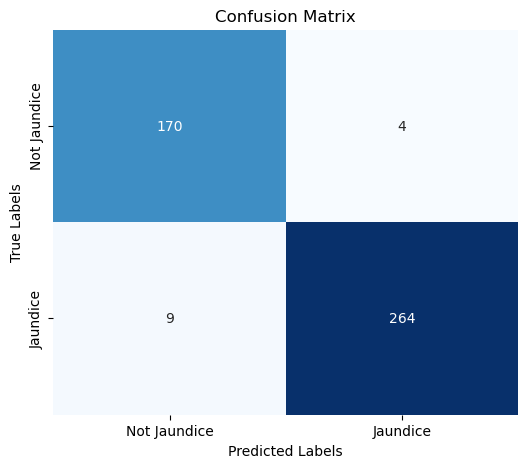

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Jaundice', 'Jaundice'],
            yticklabels=['Not Jaundice', 'Jaundice'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [18]:
from sklearn.metrics import confusion_matrix, classification_report

report = classification_report(y_true_labels, y_pred_labels, target_names=["Not Jaundice", "Jaundice"])
print("\nClassification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

Not Jaundice       0.95      0.98      0.96       174
    Jaundice       0.99      0.97      0.98       273

    accuracy                           0.97       447
   macro avg       0.97      0.97      0.97       447
weighted avg       0.97      0.97      0.97       447

